# Mounting the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Setting the working directory

In [ ]:
import os

# Set your working directory to a folder in your Google Drive. This way, if your notebook times out,
# your files will be saved in your Google Drive!

# the base Google Drive directory
root_dir = "/content/drive/My Drive/"

# choose where you want your project files to be saved
project_folder = "Colab Notebooks/ML_project/"

def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

  # create a test file to make sure it shows up in the right place
  !touch 'new_file_in_working_directory.txt'
  print('\nYour working directory was changed to ' + root_dir + project_folder + \
        "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )

create_and_set_working_directory(project_folder)


Your working directory was changed to /content/drive/My Drive/Colab Notebooks/ML_project/

An empty text file was created there. You can also run !pwd to confirm the current working directory.


# Importing necessary libraries

In [ ]:
import tensorflow
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from glob import glob
import seaborn as sns

import torch
import torchvision.models as models
from torchvision import datasets, transforms
from torch import optim
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
import random
from termcolor import colored
from sklearn.metrics import confusion_matrix
import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
#from TSNE import bh_sne
import matplotlib.patches as patches
from PIL import Image
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec

import numpy as np
from skimage.feature import greycomatrix, greycoprops
from skimage.feature import local_binary_pattern

from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='skimage.feature')

In [ ]:
# Save me from cuda - useful cuda stuff
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
! nvidia-smi

Mon Apr 17 18:48:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    29W /  70W |    369MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Defining useful functions

In [ ]:
# Loading/reading the images using OpenCV (does it in BGR mode). Matplotlib requires images to be converted to the RGB mode

# converts the bgr to rgb images
def readImage_rgb(img_path):
    '''OpenCV loads color images in BGR mode and converts to RGB mode for visualization;
       output: (H x W x n_channel)'''
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    return img_rgb

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

def plot_confusion_matrix(cm, classes,title='Confusion matrix',cmap=plt.cm.Blues):
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=26)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12, fontweight='bold')
    plt.yticks(tick_marks, classes, fontsize=12, fontweight='bold')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:d} \n({:.2f}%)'.format(cm[i, j], cm[i,j]/cm.sum()*100), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)
    plt.tight_layout()

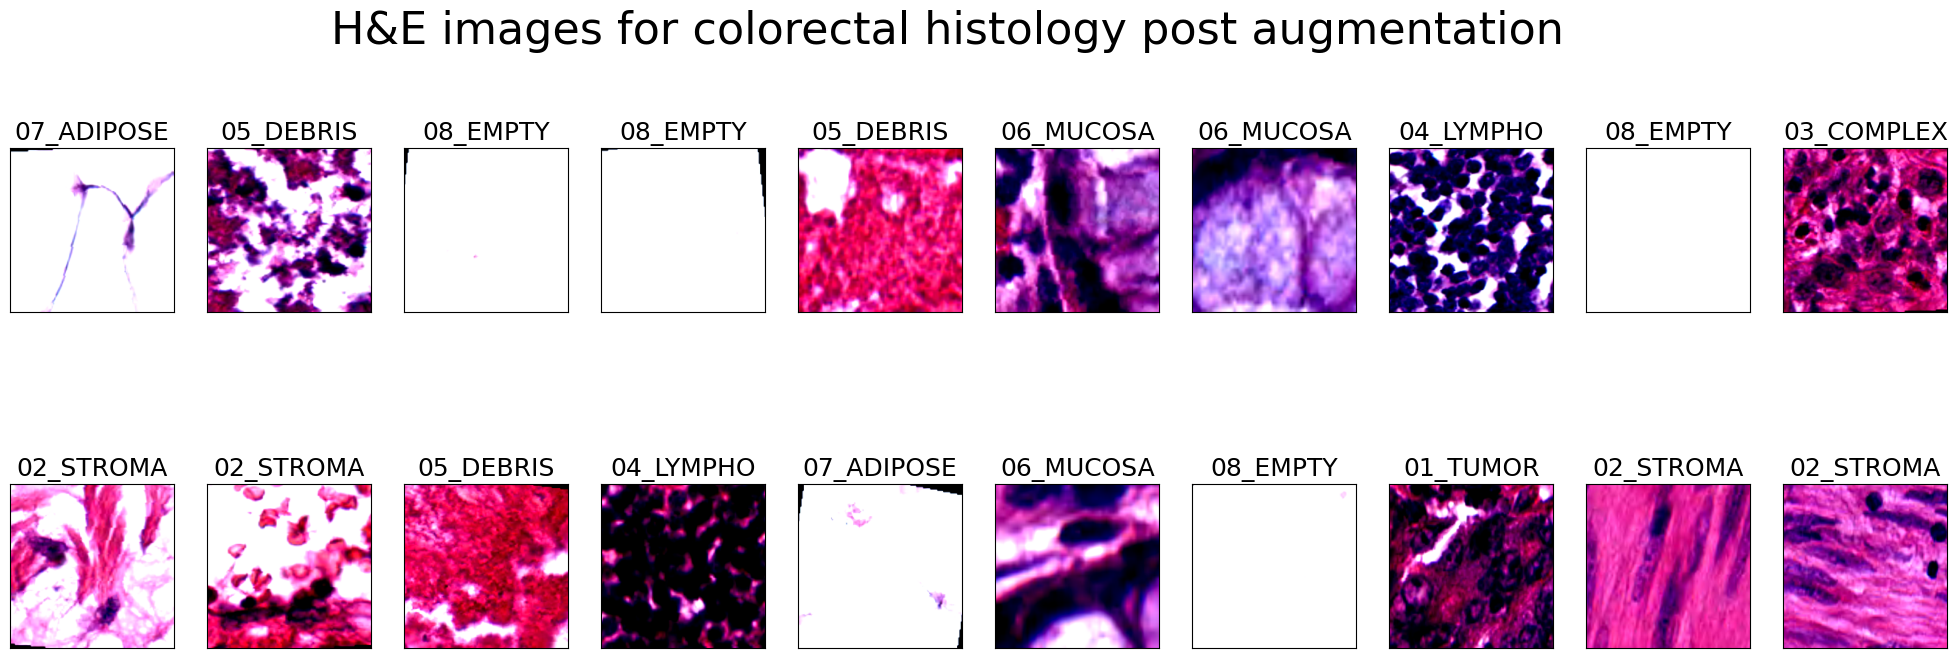

In [ ]:
def imshow_transform(img):
    '''visualize images post augmentation'''
    img = img*0.5+0.5
    plt.imshow(np.transpose(img, (1,2,0)))

images, labels = next(iter(train_loader))
images = images.numpy().squeeze()
classes = train_data.classes
palette = sns.color_palette('tab10', 8)

fig = plt.figure(figsize = (25,8))
for idx in np.arange(20):
    ax = fig.add_subplot(2,10,idx+1,xticks=[], yticks=[])
    imshow_transform(images[idx])
    ax.set_title(classes[labels.numpy()[idx]], fontsize=18)
fig.suptitle('H&E images for colorectal histology post augmentation', fontsize = 32)

def train(n_epochs, train_loader, val_loader, model, criterion, optimizer, device, save_path, save_csv):
    '''the train function will perform both forward and backpropagation on training and validation datasets.
    Output: trained model with the lowest val_loss and dataframe containing train_loss/train_acc and val_loss/val_acc for each epoch'''
    epoch_dict={}
    valid_loss_min = np.Inf
    model = model.to(device)
    for epoch in np.arange(n_epochs):
        # Initiate loss and accuracy values
        train_loss = 0.0
        train_acc = 0.0
        val_loss = 0.0
        val_acc = 0.0
        epoch_dict[epoch] = {}
        # Training
        model.train()
        for images, labels in train_loader:
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            ## Update loss and acc values for the training process
            train_loss += loss.item()*images.shape[0]
            _, top_class = output.topk(1,dim=1)
            equals = top_class == labels.view(*top_class.shape)
            train_acc += torch.mean(equals.type(torch.FloatTensor)).item()

        # Validation
        else:
            # turn off gradients
            with torch.no_grad():
                # set model to evaluation mode
                model.eval()
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    output = model(images)
                    loss = criterion(output, labels)
                    ## Update loss and acc values for the validation process
                    val_loss += loss.item()*images.shape[0]
                    _, top_class = output.topk(1,dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    val_acc += torch.mean(equals.type(torch.FloatTensor)).item()

                ### write training/validation loss/accuracy
                epoch_dict[epoch]['Train_Loss'] = train_loss/len(train_loader.sampler)
                epoch_dict[epoch]['Train_Accuracy'] = train_acc/len(train_loader)
                epoch_dict[epoch]['Val_Loss'] = val_loss/len(val_loader.sampler)
                epoch_dict[epoch]['Val_Accuracy'] = val_acc/len(val_loader)

                print("Epoch: {}/{}.. ".format(epoch+1, n_epochs),
                      "Train Loss: {:.3f}.. ".format(train_loss/len(train_loader.sampler)),
                      "Train Accuracy: {:.3f}.. ".format(train_acc/len(train_loader)),
                      "Validation Loss: {:.3f}.. ".format(val_loss/len(val_loader.sampler)),
                      "Validation Accuracy: {:.3f}".format(val_acc/len(val_loader)))

                ## save the model with the lowest val_loss and update valid_loss_min
                if val_loss <= valid_loss_min:
                    print('Validation loss decreased -- Saving model -- \n')
                    torch.save(model.state_dict(), save_path)
                    valid_loss_min = val_loss

    epoch_df = pd.DataFrame.from_dict(epoch_dict, orient='index')
    epoch_df['Epoch'] = np.arange(n_epochs) + 1

    # Save the DataFrame to a CSV file
    epoch_df.to_csv(save_csv, index=False)  # Add this line to save the DataFrame to a CSV file

    return model, epoch_df

    # Evaluate performance


def model_eval(test_loader, model, criterion, device, classes):
    '''Apply the trained model to testing dataset and summarize the overall test_loss/test_acc
    also output testing accuracy for each category and the prediction result for each sample as well as the probability'''
    # Initiate loss and accuracy values
    test_loss = 0.0
    test_acc = 0.0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))

    dt = np.dtype(int)
    true_label = np.array([], dtype = dt)
    pred_label = np.array([], dtype = dt)
    path_array = np.array([])
    prob_array = np.array([])
    probs_array = np.array(classes).reshape(1,-1)

    model = model.to(device)
    with torch.no_grad():
        model.eval()
        for images, labels, paths in test_loader:
            path_array = np.append(path_array, np.array(paths))
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            test_loss += loss.item()*images.shape[0]

            softmax = nn.Softmax(dim=1)
            output_softmax = softmax(output)
            top_probs, preds = output_softmax.topk(1,dim=1)
            equals = preds == labels.view(*preds.shape)
            correct = np.squeeze(equals)
            test_acc += torch.mean(equals.type(torch.FloatTensor)).item()
            for i in range(len(images)):
                label = labels[i].item()
                class_correct[label] += correct[i].item()
                class_total[label] += 1

            if device.type == 'cpu':
                true_label = np.append(true_label, labels)
                pred_label = np.append(pred_label, preds)
                prob_array = np.append(prob_array, top_probs)
                probs_array = np.concatenate((probs_array, output_softmax))

            else:
                true_label = np.append(true_label, labels.cpu())
                pred_label = np.append(pred_label, preds.cpu())
                prob_array = np.append(prob_array, top_probs.cpu())
                probs_array = np.concatenate((probs_array, output_softmax.cpu()))


    test_loss = test_loss/len(test_loader.sampler)
    test_acc = test_acc/len(test_loader)
    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('Test Accuracy (Overall): {:.3f}%  ({}/{})\n'.format(np.sum(class_correct)/np.sum(class_total)*100, np.sum(class_correct), np.sum(class_total)))

    for i in range(len(classes)):
        if class_total[i] > 0:
            print('Test Accuracy of {}: {:.3f}% ({}/{})'.format(classes[i], class_correct[i]/class_total[i]*100,class_correct[i], class_total[i]))
        else:
            print('Test Accuracy of {}: N/A'.format(classes[i]))
    summary_df = pd.DataFrame({'category': classes, 'correct': class_correct, 'total': class_total})
    pred_df = pd.DataFrame({'file_path': path_array, 'true_label': true_label, 'prediction': pred_label, 'prob': prob_array})
    probs_df = pd.DataFrame(probs_array[1:], columns = probs_array[0])
    probs_df['file_path'] = path_array
    pred_df = pred_df.merge(probs_df, left_on = 'file_path', right_on = 'file_path')
    return summary_df, pred_df

def model_eval_resnet50(test_loader, model, criterion, device, classes):
    '''Apply the trained model to testing dataset and summarize the overall test_loss/test_acc
    also output testing accuracy for each category and the prediction result for each sample as well as the probability'''
    # Initiate loss and accuracy values
    test_loss = 0.0
    test_acc = 0.0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))

    dt = np.dtype(int)
    true_label = np.array([], dtype=dt)
    pred_label = np.array([], dtype=dt)
    path_array = np.array([])
    prob_array = np.array([])
    probs_array = np.array(classes).reshape(1, -1)

    model = model.to(device)
    with torch.no_grad():
        model.eval()
        for images, labels, paths in test_loader:
            path_array = np.append(path_array, np.array(paths))
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            #print(output.shape)
            loss = criterion(output, labels)
            test_loss += loss.item() * images.shape[0]

            softmax = nn.Softmax(dim=1)
            output_softmax = softmax(output)
            top_probs, preds = output_softmax.topk(1, dim=1)
            equals = preds == labels.view(*preds.shape)
            correct = np.squeeze(equals)
            test_acc += torch.mean(equals.type(torch.FloatTensor)).item()
            for i in range(len(images)):
                label = labels[i].item()
                class_correct[label] += correct[i].item()
                class_total[label] += 1

            if device.type == 'cpu':
                true_label = np.append(true_label, labels)
                pred_label = np.append(pred_label, preds)
                prob_array = np.append(prob_array, top_probs)
                probs_array = np.concatenate((probs_array, output_softmax))

            else:
                true_label = np.append(true_label, labels.cpu())
                pred_label = np.append(pred_label, preds.cpu())
                prob_array = np.append(prob_array, top_probs.cpu())
                probs_array = np.concatenate((probs_array, output_softmax.cpu()))

    test_loss = test_loss / len(test_loader.sampler)
    test_acc = test_acc / len(test_loader)
    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('Test Accuracy (Overall): {:.3f}%  ({}/{})\n'.format(np.sum(class_correct) / np.sum(class_total) * 100,
                                                                 np.sum(class_correct), np.sum(class_total)))

    for i in range(len(classes)):
        if class_total[i] > 0:
            print('Test Accuracy of {}: {:.3f}% ({}/{})'.format(classes[i], class_correct[i] / class_total[i] * 100,
                                                                class_correct[i], class_total[i]))
        else:
            print('Test Accuracy of {}: N/A'.format(classes[i]))

    summary_df = pd.DataFrame({'category': classes, 'correct': class_correct, 'total': class_total})
    pred_df = pd.DataFrame({'file_path': path_array, 'true_label': true_label, 'prediction': pred_label, 'prob': prob_array})
    probs_df = pd.DataFrame(probs_array[1:], columns = probs_array[0])
    probs_df['file_path'] = path_array
    pred_df = pred_df.merge(probs_df, left_on = 'file_path', right_on = 'file_path')
    return summary_df, pred_df


# Loading images

In [ ]:
base_dir = "/content/drive/MyDrive/colorectal_images/Kather_texture_2016_image_tiles_5000"

# Labels of the different images in this dataset

img_labels = [i for i in os.listdir(base_dir) if not i.startswith('.')]
img_labels = sorted(img_labels)
print('There are {} classes in this dataset:\n{}'.format(len(img_labels), img_labels))

print(len(img_labels))

print(img_labels*625)

There are 8 classes in this dataset:
['01_TUMOR', '02_STROMA', '03_COMPLEX', '04_LYMPHO', '05_DEBRIS', '06_MUCOSA', '07_ADIPOSE', '08_EMPTY']
8
['01_TUMOR', '02_STROMA', '03_COMPLEX', '04_LYMPHO', '05_DEBRIS', '06_MUCOSA', '07_ADIPOSE', '08_EMPTY', '01_TUMOR', '02_STROMA', '03_COMPLEX', '04_LYMPHO', '05_DEBRIS', '06_MUCOSA', '07_ADIPOSE', '08_EMPTY', '01_TUMOR', '02_STROMA', '03_COMPLEX', '04_LYMPHO', '05_DEBRIS', '06_MUCOSA', '07_ADIPOSE', '08_EMPTY', '01_TUMOR', '02_STROMA', '03_COMPLEX', '04_LYMPHO', '05_DEBRIS', '06_MUCOSA', '07_ADIPOSE', '08_EMPTY', '01_TUMOR', '02_STROMA', '03_COMPLEX', '04_LYMPHO', '05_DEBRIS', '06_MUCOSA', '07_ADIPOSE', '08_EMPTY', '01_TUMOR', '02_STROMA', '03_COMPLEX', '04_LYMPHO', '05_DEBRIS', '06_MUCOSA', '07_ADIPOSE', '08_EMPTY', '01_TUMOR', '02_STROMA', '03_COMPLEX', '04_LYMPHO', '05_DEBRIS', '06_MUCOSA', '07_ADIPOSE', '08_EMPTY', '01_TUMOR', '02_STROMA', '03_COMPLEX', '04_LYMPHO', '05_DEBRIS', '06_MUCOSA', '07_ADIPOSE', '08_EMPTY', '01_TUMOR', '02_STROMA'

In [ ]:
# Setting the paths for all the images in the given class

tumor_files = glob(os.path.join(base_dir, img_labels[0], '*.tif'))
stroma_files = glob(os.path.join(base_dir, img_labels[1], '*.tif'))
complex_files = glob(os.path.join(base_dir, img_labels[2], '*.tif'))
lympho_files = glob(os.path.join(base_dir, img_labels[3], '*.tif'))
debris_files = glob(os.path.join(base_dir, img_labels[4], '*.tif'))
mucosa_files = glob(os.path.join(base_dir, img_labels[5], '*.tif'))
adipose_files = glob(os.path.join(base_dir, img_labels[6], '*.tif'))
empty_files = glob(os.path.join(base_dir, img_labels[7], '*.tif'))
img_files = [tumor_files, stroma_files, complex_files, lympho_files, debris_files, mucosa_files, adipose_files, empty_files]
total_files = [img for folder in img_files for img in folder]

In [ ]:
# Checking the total number of images across all classes

print('Total number of images in this dataset: {}'.format(len(total_files)))
print ('-'*50)
for i in np.arange(8):
    print('Number of images for {} category: {}'.format(img_labels[i].split('_')[1], len(img_files[i])))

Total number of images in this dataset: 5000
--------------------------------------------------
Number of images for TUMOR category: 625
Number of images for STROMA category: 625
Number of images for COMPLEX category: 625
Number of images for LYMPHO category: 625
Number of images for DEBRIS category: 625
Number of images for MUCOSA category: 625
Number of images for ADIPOSE category: 625
Number of images for EMPTY category: 625


In [ ]:
gt_labels = []
name_labels = []

for i, label in enumerate(img_labels):
    gt_labels += [i] * 625
    name_labels += [label] * 625

gt_labels = np.array(gt_labels)
name_labels = np.array(name_labels)

gt_labels
print(name_labels)

#np.bincount(gt_labels)

['01_TUMOR' '01_TUMOR' '01_TUMOR' ... '08_EMPTY' '08_EMPTY' '08_EMPTY']


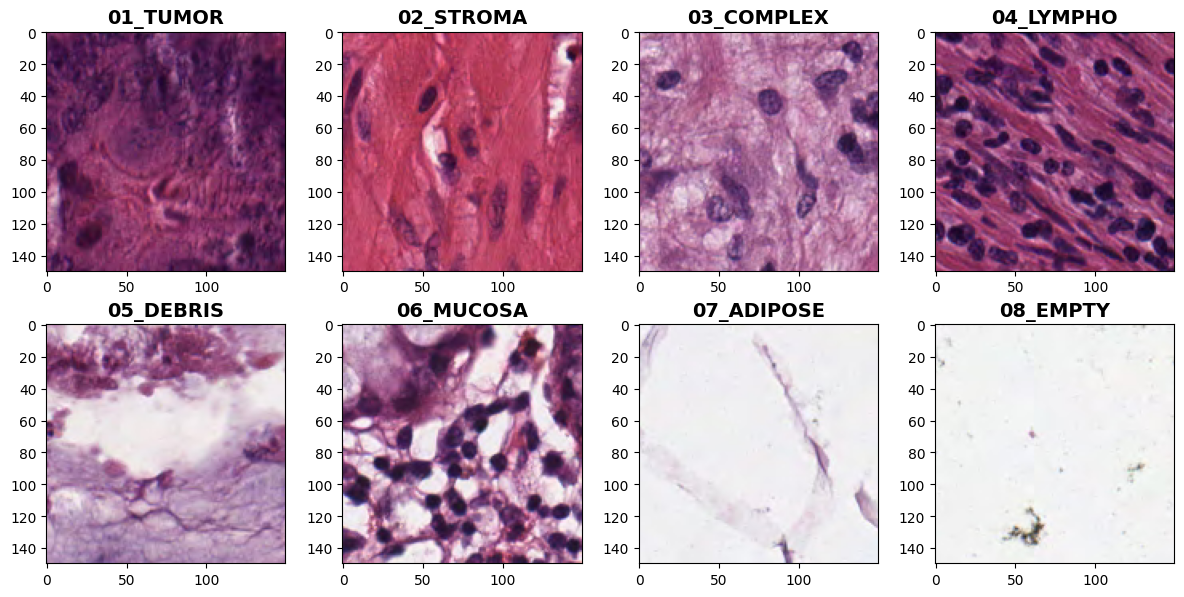

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(12, 6))

for i in range(8):
    j = i * 625
    plt.subplot(2, 4, i+1)
    plt.imshow(data[j])
    plt.title(img_labels[gt_labels[j]], fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()



In [ ]:
# Dont run this - data is reshaped and saved in data.npy in the colorectal images file
# data = readImage_rgb(total_files[0])
# data =data.reshape(1,150,150,3)

# data.shape
# for path in total_files[1:]:
#     image = readImage_rgb(path).reshape(1,150,150,3)

#     data = np.vstack((data, image))




In [ ]:
#np.save('/content/drive/MyDrive/colorectal_images/data.npy',data)
data = np.load('/content/drive/MyDrive/colorectal_images/data.npy') # data is a 4D array with shape (n_samples, height, width, channels)

# This code shows the first picture of all the 8 classes arranged in the order needed for the model
# plt.imshow(data[0])
# data[0].shape
# plt.title(img_labels[gt_labels[0]]);

# for i in range(8):
#     j = i * 625
#     plt.figure()
#     plt.imshow(data[j])
#     data[j].shape
#     plt.title(img_labels[gt_labels[j]])

# Unsupervised Methods (Clustering)

# K means clustering + LBP features

### Feature extraction


#### Features from LBP

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from sklearn.cluster import KMeans
from sklearn import metrics

# Define the parameters for LBP feature extraction
radius = 3
n_points = 8 * radius
props = ['mean', 'std']

# Create an empty array to store the LBP-based features for each image
features = np.zeros((data.shape[0], n_points*3))

# Extract LBP-based features for each image
for i in range(data.shape[0]):
    gray = np.mean(data[i], axis=-1).astype('uint8')  # Convert to grayscale
    lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
    for j, prop in enumerate(props):
        features[i, j::len(props)] = getattr(np, prop)(lbp).ravel()

# Normalize the features to have zero mean and unit variance
features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)

In [ ]:
features.shape

(5000, 72)

In [ ]:
from sklearn import datasets
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(4, 2, figsize=(15, 16))
for i in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
    '''
    Create KMeans instances for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i-2, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q][mod])
    visualizer.fit(features)


In [ ]:
from sklearn import datasets, metrics
# Looking at which K gives the best cluster score

## Check which number of clusters works best
n_cluster_list = [2,3,4,5,6,7,8, 9, 10] # there can't be more clusters as n

elb = []
silhouette = []
for n_clusters in n_cluster_list:
   #iterating through cluster sizes
   clusterer = KMeans(n_clusters = n_clusters, random_state=42)
   cluster_labels = clusterer.fit_predict(features)
   #Finding the average silhouette score
   silhouette_avg = metrics.silhouette_score(features, cluster_labels)
   silhouette.append(silhouette_avg)
   #print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_avg)
   #Finding the average SSE"
   elb.append(clusterer.inertia_) # Inertia: Sum of distances of samples to their closest cluster center

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

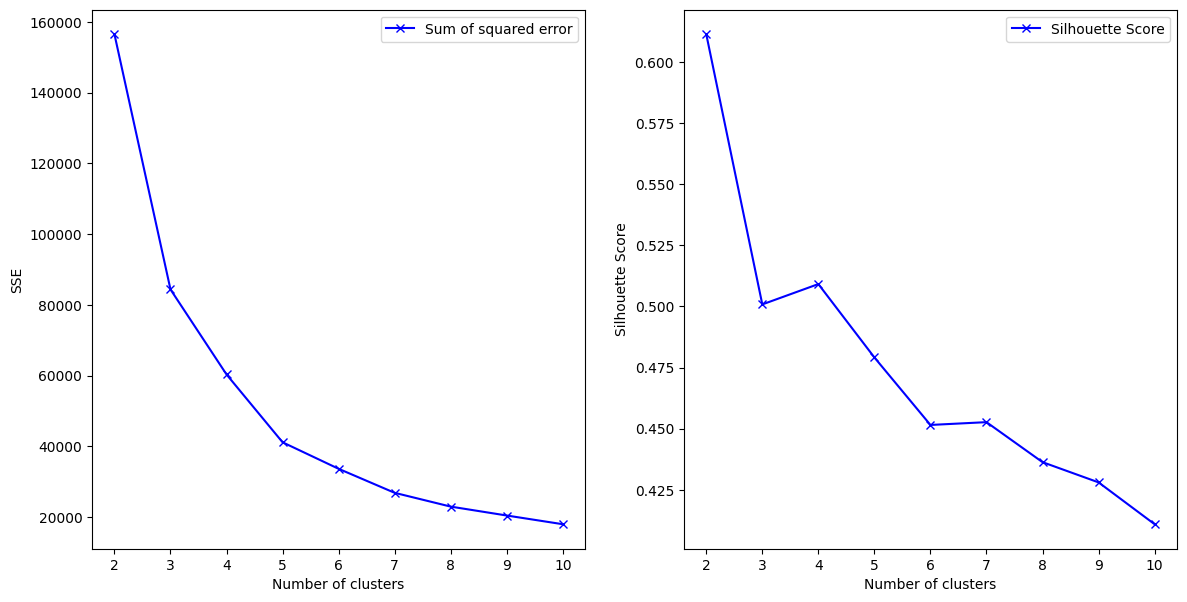

In [ ]:
fig = plt.figure(figsize=(14,7))
fig.add_subplot(121)
plt.plot(n_cluster_list, elb,'bx-',label='Sum of squared error')
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.legend()
fig.add_subplot(122)
plt.plot(n_cluster_list, silhouette,'bx-',label='Silhouette Score')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from sklearn.cluster import KMeans

# Define the parameters for LBP feature extraction
radius = 3
n_points = 8 * radius
props = ['mean', 'std']

# Create an empty array to store the LBP-based features for each image
features = np.zeros((data.shape[0], n_points*3))

# Extract LBP-based features for each image
for i in range(data.shape[0]):
    gray = np.mean(data[i], axis=-1).astype('uint8')  # Convert to grayscale
    lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
    for j, prop in enumerate(props):
        features[i, j::len(props)] = getattr(np, prop)(lbp).ravel()

# Normalize the features to have zero mean and unit variance
features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


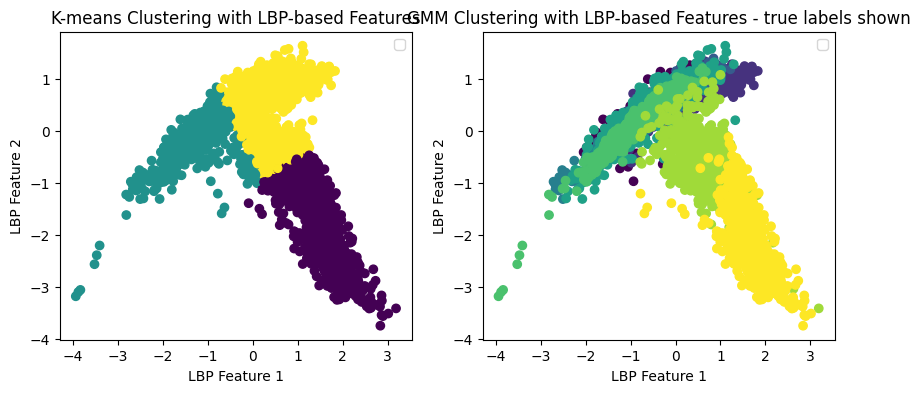

In [ ]:
# Perform unsupervised learning using K-means clustering
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(features)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Visualize the results with a scatter plot
axs[0].scatter(features[:, 0], features[:, 1], c=kmeans.labels_, cmap='viridis')
axs[0].set_xlabel('LBP Feature 1')
axs[0].set_ylabel('LBP Feature 2')
axs[0].set_title('K-means Clustering with LBP-based Features')
axs[0].legend()

# Visualize the results with a scatter plot
axs[1].scatter(features[:, 0], features[:, 1], c=gt_labels, cmap='viridis')
axs[1].set_xlabel('LBP Feature 1')
axs[1].set_ylabel('LBP Feature 2')
axs[1].set_title('GMM Clustering with LBP-based Features - true labels shown')
axs[1].legend()

# Add legends for the colors
for ax in axs:
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)

# Remove grid
for ax in axs:
    ax.grid(False)

plt.show()


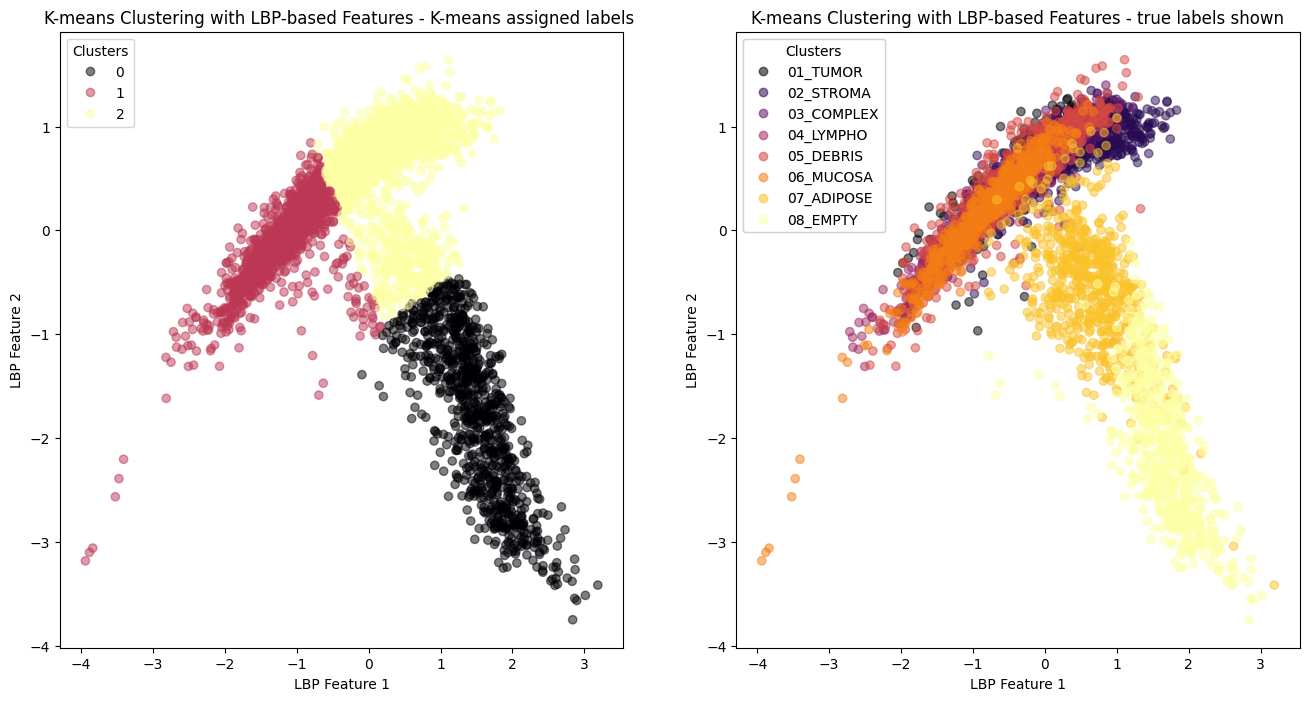

In [ ]:
# Visualize the results with a scatter plot
fig, ax = plt.subplots(1,2, figsize = (16,8))
scatter = ax[0].scatter(features[:, 0], features[:, 1], c=kmeans.labels_, cmap='inferno' , alpha=0.5)
legend = ax[0].legend(*scatter.legend_elements(),
                    loc="upper left", title="Clusters")
# plt.add_artist(legend)
ax[0].set_xlabel('LBP Feature 1')
ax[0].set_ylabel('LBP Feature 2')
ax[0].set_title('K-means Clustering with LBP-based Features - K-means assigned labels ')

scatter = ax[1].scatter(features[:, 0], features[:, 1], c=gt_labels, cmap='inferno', alpha=0.5, label = "blaj")
# Create a legend with custom labels
legend = ax[1].legend(*scatter.legend_elements(),
                    loc="upper left", title="Clusters")
for i, label in enumerate(img_labels):
    legend.get_texts()[i].set_text(label)

# plt.add_artist(legend)
ax[1].set_xlabel('LBP Feature 1')
ax[1].set_ylabel('LBP Feature 2')
ax[1].set_title('K-means Clustering with LBP-based Features - true labels shown')
ax[1].add_artist(legend)
plt.show()


In [ ]:
gt_labels

array([0, 0, 0, ..., 7, 7, 7])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


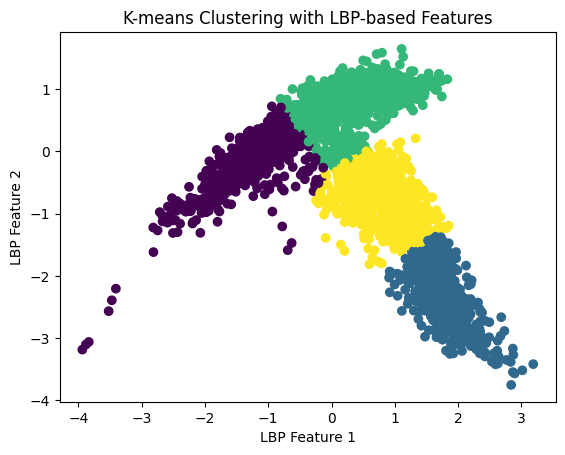

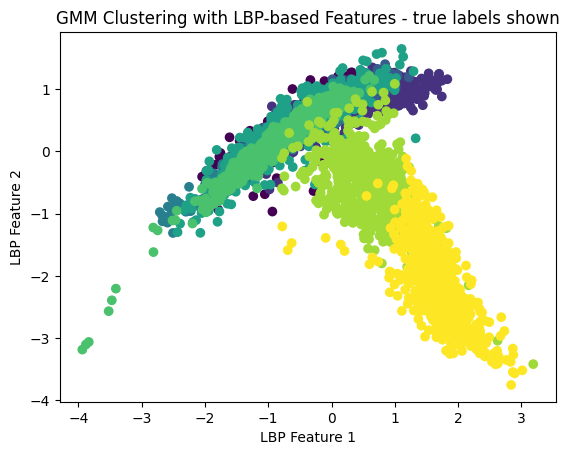

In [ ]:
# Perform unsupervised learning using K-means clustering
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(features)

# Visualize the results with a scatter plot
plt.scatter(features[:, 0], features[:, 1], c=kmeans.labels_, cmap='viridis') #c=kmeans.labels_
plt.xlabel('LBP Feature 1')
plt.ylabel('LBP Feature 2')
plt.title('K-means Clustering with LBP-based Features')
plt.show()

# Plot with gt labels

# Visualize the results with a scatter plot GMM CODE
plt.scatter(features[:, 0], features[:, 1], c=gt_labels, cmap='viridis')
plt.xlabel('LBP Feature 1')
plt.ylabel('LBP Feature 2')
plt.title('GMM Clustering with LBP-based Features - true labels shown')
plt.show()

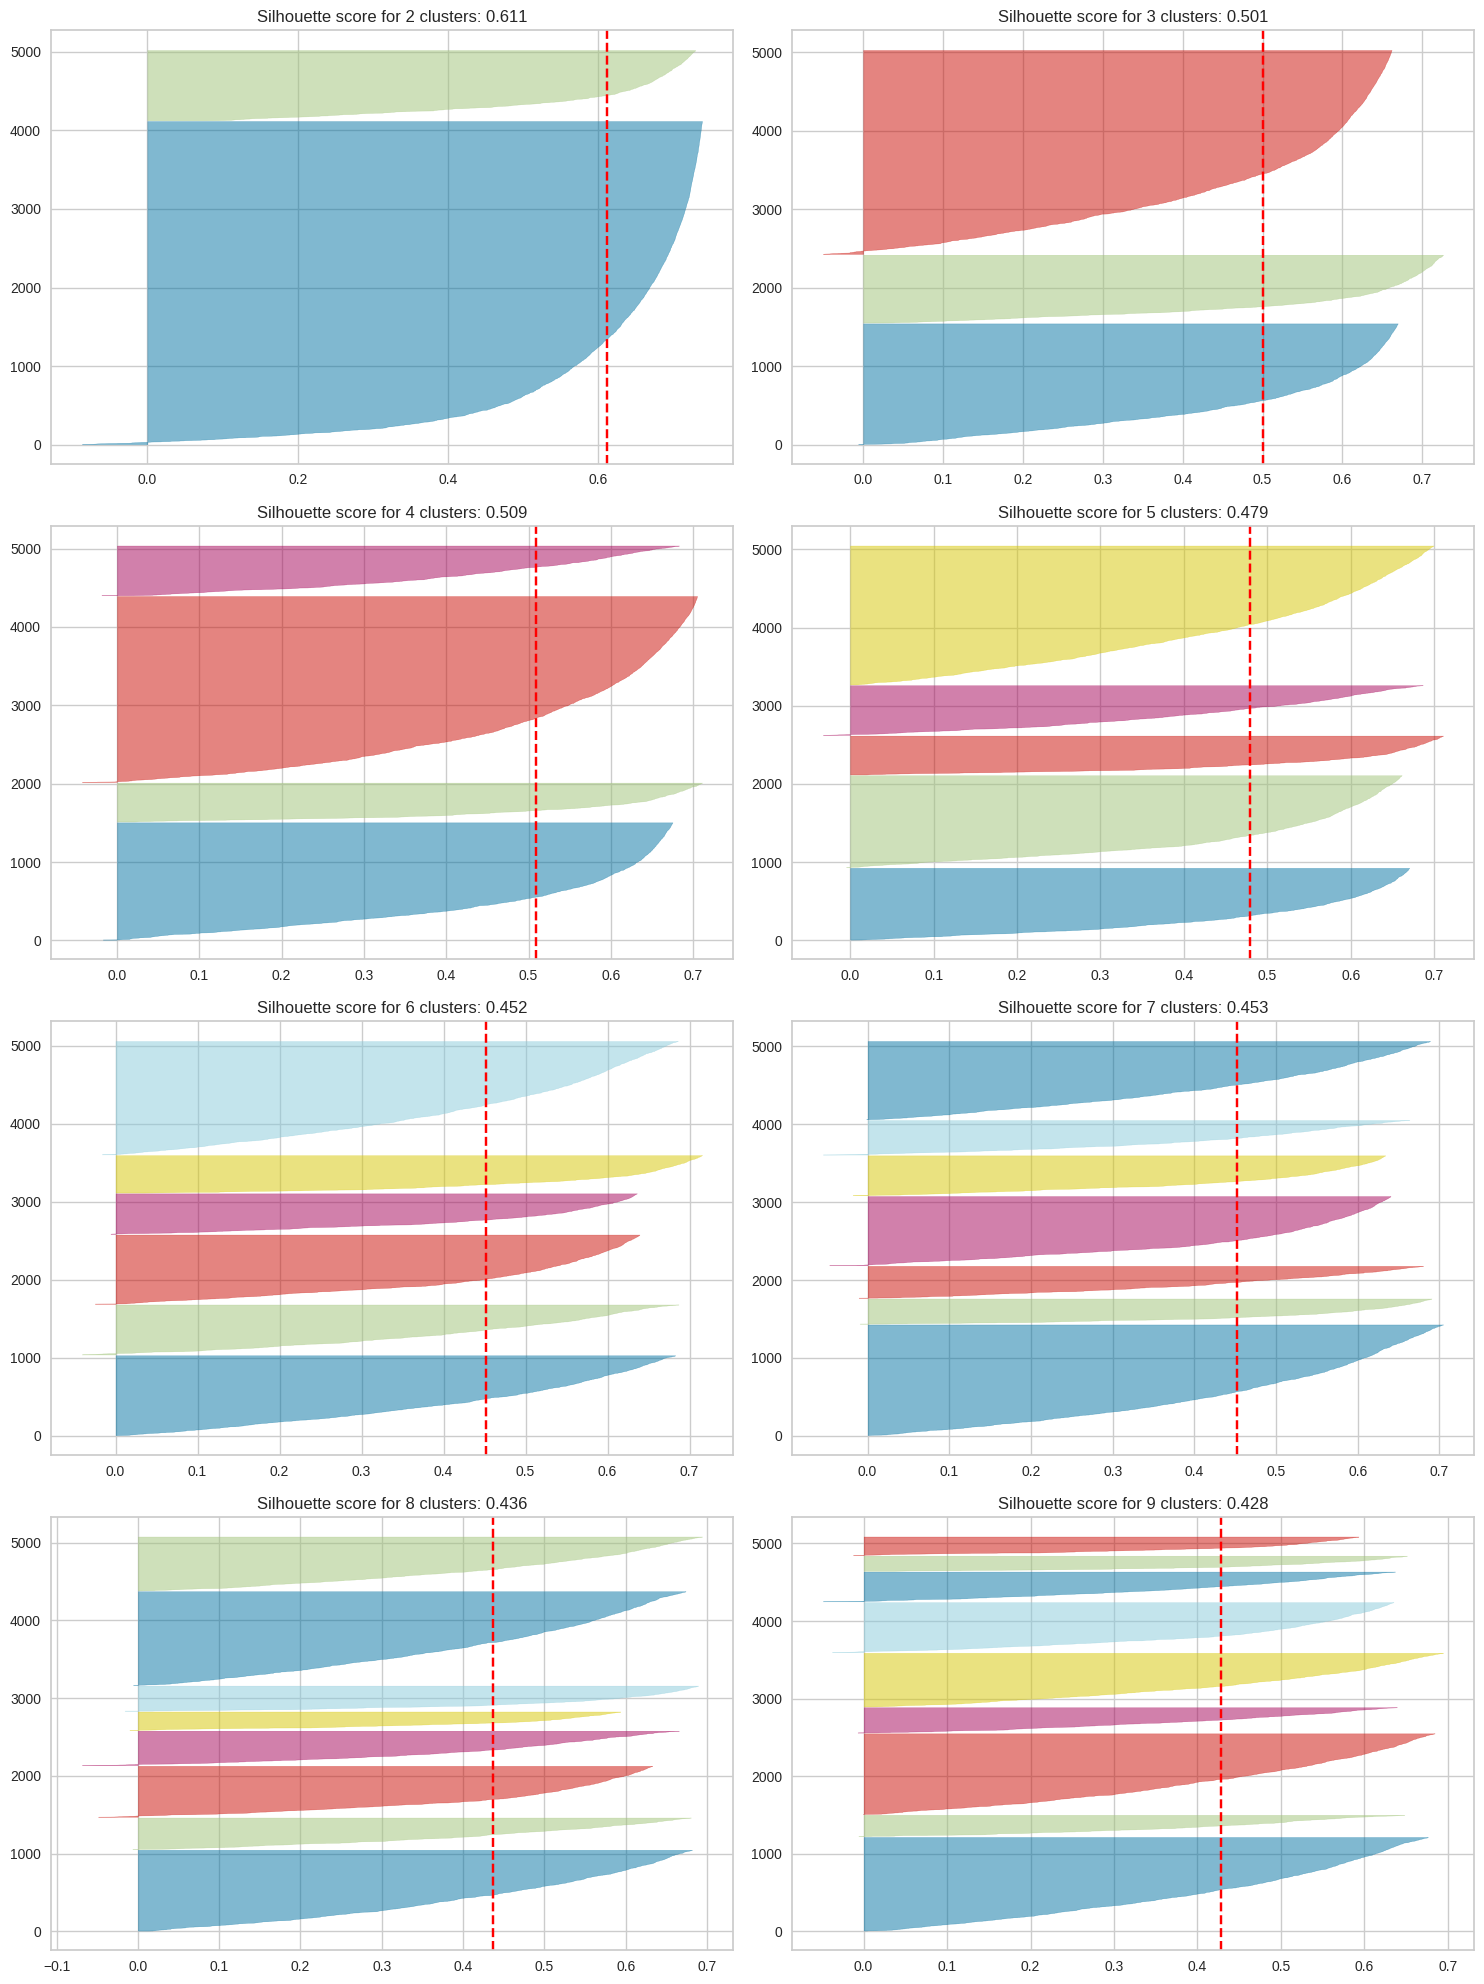

<Figure size 800x550 with 0 Axes>

In [ ]:
from sklearn import datasets
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(4, 2, figsize=(15, 20))

for i in range(2, 10):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i-2, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q][mod])
    visualizer.fit(features)
    ax[q][mod].set_title(f'Silhouette score for {i} clusters: {visualizer.silhouette_score_:.3f}')

fig.tight_layout()
plt.show()

import matplotlib.pyplot as plt

# Set the size of the figure to fit in a PowerPoint slide
fig.set_size_inches(7.5, 4.5)

# Save the plot as a PNG file with a resolution of 300 DPI
plt.savefig("plot.png", dpi=300, bbox_inches="tight")


## Using ResNet features for clustering



In [ ]:
# Define preprocessing
preprocess = transforms.Compose([
  transforms.ToPILImage(),
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Apply preprocess
image_tensor = torch.stack([preprocess(image) for image in data])
image_tensor.shape

torch.Size([5000, 3, 224, 224])

In [ ]:
resnet50_pretrained = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)#models.ResNet50_Weights.DEFAULT
device = torch.device("cuda:0")
resnet50_pretrained = resnet50_pretrained.to(device)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
# resnet50_pretrained

resnet50_pretrained = torch.nn.Sequential(*(list(resnet50_pretrained.children())[:-1]))

# might use if i want the class activation map
class MyResNet50(nn.Module):
    def __init__(self, pretrained_model):
        super(MyResNet50, self).__init__()
        self.pretrained = pretrained_model
        # self.my_new_layer = nn.Sequential(nn.Linear(2048, 1024),
        #                                    nn.ReLU(inplace = True),
        #                                    nn.Dropout(p=0.3),
        #                                    nn.Linear(1024, 8))

    def forward(self, x):
        x = self.pretrained(x)
        # Flatten the tensor before passing to the first linear layer
        x = x.view(x.size(0), -1)
        # x = self.my_new_layer(x)
        return x

    def get_activations(self, x):
        x = self.pretrained(x)
        # Flatten the tensor before passing to the first linear layer
        x = x.view(x.size(0), -1)
        # x = self.my_new_layer[:-1](x)
        return x

    def get_activations_gradient(self):
        return self.my_new_layer[-1].weight.grad


resnet50_featextract = MyResNet50(pretrained_model = resnet50_pretrained)
# resnet50_extended

# To make only classification layer learnable
# freezing the layers to only perform feature_extraction
#for param in resnet50_extended.parameters():
#    param.requires_grad=False

# for name, param in resnet50_extended.named_parameters() :
#     param.requires_grad = False
#     if name.startswith('my_new_layer') :
#         param.requires_grad = True

resnet50_featextract.eval()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 357MB/s]


MyResNet50(
  (pretrained): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2

In [ ]:
batch_size = 16
result = np.empty((len(image_tensor), 2048))
for i in range(0, len(image_tensor), batch_size):
  data = image_tensor[i:i+batch_size].to(device)
  output = resnet50_featextract(data)
  output = torch.flatten(output, 1)
  result[i:i+batch_size] = output.detach().cpu().numpy()


In [ ]:
result = np.load('/content/drive/MyDrive/colorectal_images/extracted_features_resnet50.npy')
result.shape
#np.save('/content/drive/MyDrive/colorectal_images/extracted_features_resnet50.npy',result)

(5000, 2048)

In [ ]:
# Cluster the resnet features using K-Means
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(result)

# Create a 3D scatter plot of the clustered features
fig = px.scatter_3d(result, x=0, y=1, z=2, color=labels)
fig.show()

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
import plotly.express as px
# Create a 3D scatter plot of the clustered features
fig = px.scatter_3d(result, x=0, y=1, z=2, color=gt_labels)
fig.show()

NameError: ignored

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.express as px
from sklearn.preprocessing import StandardScaler

# Instantiate PCA object with two components
pca = PCA(n_components=0.95, random_state=42)

# Fit and transform the extracted features
pca_features = pca.fit_transform(result)
pca_features.shape

(5000, 325)

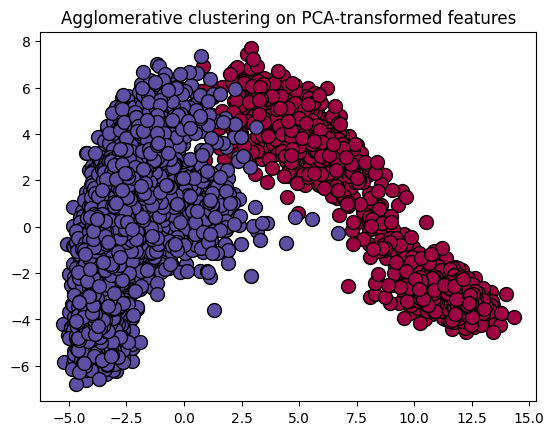

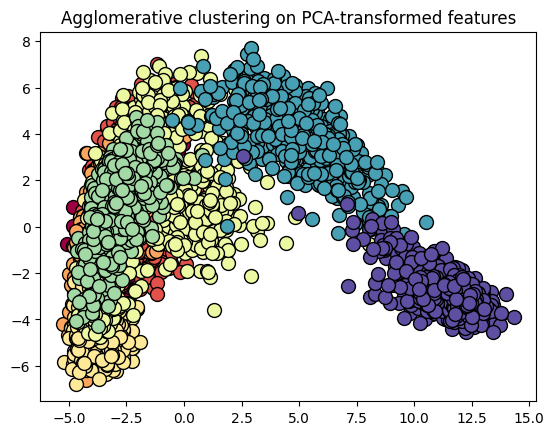

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Instantiate PCA object with two components
pca = PCA(random_state=42)

# Fit and transform the extracted features
pca_features = pca.fit_transform(result)

# Initialize the clustering algorithm
agg_clustering = AgglomerativeClustering()

# Fit the model to the PCA-transformed features
agg_clustering.fit(pca_features)

# Plot the clustering results
labels = agg_clustering.labels_
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    xy = pca_features[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=10)

plt.title('Agglomerative clustering on PCA-transformed features')
plt.show()

# Plot the clustering results
labels = gt_labels
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    xy = pca_features[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=10)

plt.title('Agglomerative clustering on PCA-transformed features')
plt.show()

#### Features from frozen resnet50

In [ ]:
result = np.load('/content/drive/MyDrive/colorectal_images/extracted_features_resnet50.npy')
result.shape

(5000, 2048)

### K-means on both (with optimization)

In [ ]:
from sklearn import metrics

## Check which number of clusters works best
n_cluster_list = [2,3,4,5,6,7,8, 9, 10, 11, 12, 13, 14, 15] # there can't be more clusters as n

elb = []
silhouette = []
for n_clusters in n_cluster_list:
   #iterating through cluster sizes
   clusterer = KMeans(n_clusters = n_clusters, random_state=42)
   cluster_labels = clusterer.fit_predict(features)
   #Finding the average silhouette score
   silhouette_avg = metrics.silhouette_score(features, cluster_labels)
   silhouette.append(silhouette_avg)
   print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_avg)
   #Finding the average SSE"
   elb.append(clusterer.inertia_) # Inertia: Sum of distances of samples to their closest cluster center

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 2 The average silhouette_score is : 0.6112716078340272


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 3 The average silhouette_score is : 0.5008126808486354


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 4 The average silhouette_score is : 0.5091278367504086


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 5 The average silhouette_score is : 0.47912951196968245


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 6 The average silhouette_score is : 0.4515360648643329


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 7 The average silhouette_score is : 0.4526782636060686


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 8 The average silhouette_score is : 0.4363229322119578


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 9 The average silhouette_score is : 0.4280520004857134


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 10 The average silhouette_score is : 0.410950740121534


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 11 The average silhouette_score is : 0.4068115599100286


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 12 The average silhouette_score is : 0.40063782564299233


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 13 The average silhouette_score is : 0.39173494117530405


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 14 The average silhouette_score is : 0.39333701359516365


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 15 The average silhouette_score is : 0.3733728106890955


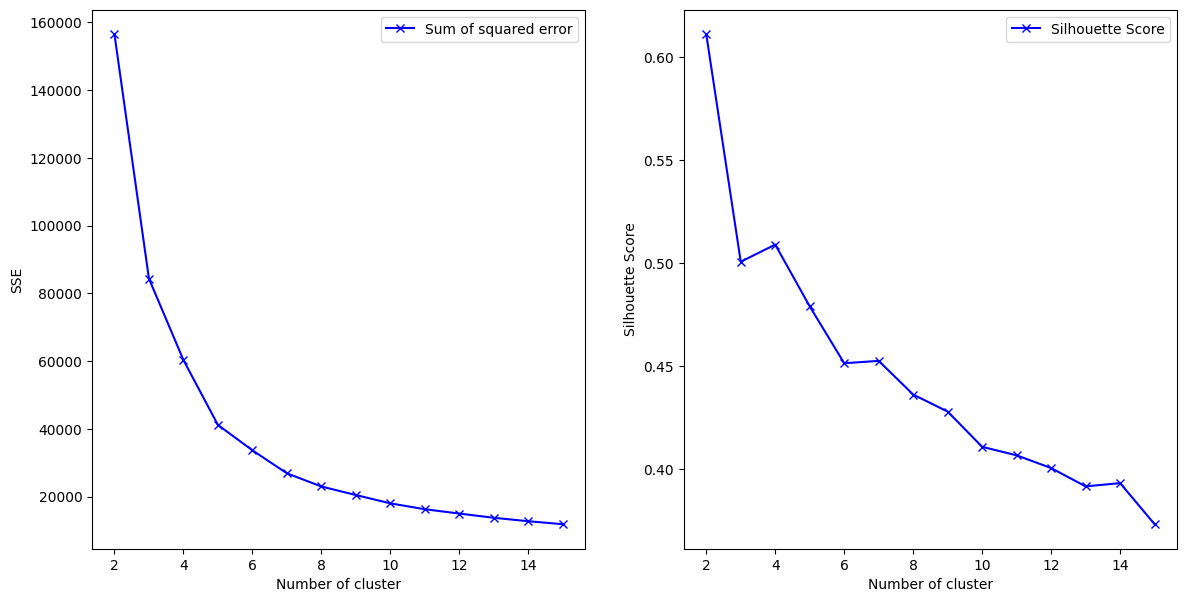

In [ ]:
fig = plt.figure(figsize=(14,7))
fig.add_subplot(121)
plt.plot(n_cluster_list, elb,'bx-',label='Sum of squared error')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.legend()
fig.add_subplot(122)
plt.plot(n_cluster_list, silhouette,'bx-',label='Silhouette Score')
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Score")
plt.legend()
plt.show()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn import mixture

# Scale the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(result)

# Perform PCA on scaled data
pca = PCA(n_components=2, random_state = 42)
data_3d = pca.fit_transform(data_scaled)

total_var = pca.explained_variance_ratio_.sum() * 100
total_var

13.0938106444353

In [ ]:
## Check which number of clusters works best
n_cluster_list = [2,3,4,5,6,7,8, 9, 10, 11, 12, 13, 14, 15] # there can't be more clusters as n

elb = []
silhouette = []
for n_clusters in n_cluster_list:
   #iterating through cluster sizes
   clusterer = KMeans(n_clusters = n_clusters, random_state=42)
   cluster_labels = clusterer.fit_predict(pca_features)
   #Finding the average silhouette score
   silhouette_avg = metrics.silhouette_score(pca_features, cluster_labels)
   silhouette.append(silhouette_avg)
   print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_avg)
   #Finding the average SSE"
   elb.append(clusterer.inertia_) # Inertia: Sum of distances of samples to their closest cluster center

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 2 The average silhouette_score is : 0.5718227368918986


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 3 The average silhouette_score is : 0.5495715382813289


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 4 The average silhouette_score is : 0.4812912346197805


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 5 The average silhouette_score is : 0.43450806354588656


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 6 The average silhouette_score is : 0.4468075413345483


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 7 The average silhouette_score is : 0.4130361295552442


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 8 The average silhouette_score is : 0.38363809741157995


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 9 The average silhouette_score is : 0.3988900782426497


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 10 The average silhouette_score is : 0.39137471929554274


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 11 The average silhouette_score is : 0.3918182827412001


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 12 The average silhouette_score is : 0.3835436500701563


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 13 The average silhouette_score is : 0.3586691010847855


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 14 The average silhouette_score is : 0.34986333663723235


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 15 The average silhouette_score is : 0.34548997915235713


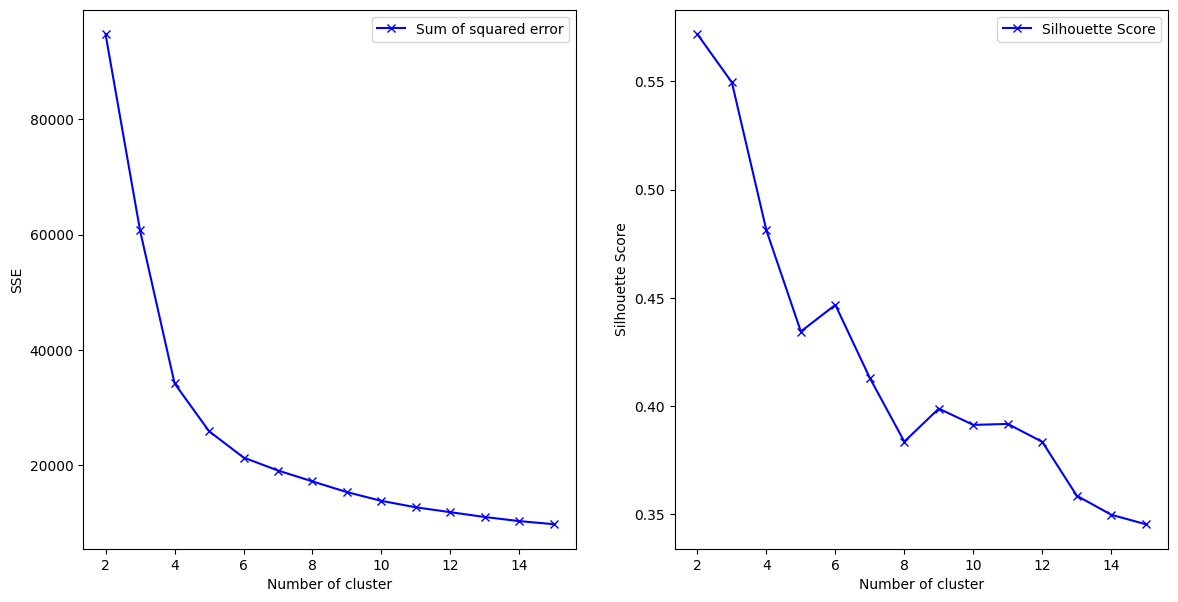

In [ ]:
fig = plt.figure(figsize=(14,7))
fig.add_subplot(121)
plt.plot(n_cluster_list, elb,'bx-',label='Sum of squared error')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.legend()
fig.add_subplot(122)
plt.plot(n_cluster_list, silhouette,'bx-',label='Silhouette Score')
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Score")
plt.legend()
plt.show()

# Supervised methods

# Image pre-processing and data loading (from the notebook) DL methods

In [ ]:
total_num = 5000
split1 = int(total_num*0.7) # split of 0.7, 0.15, 0.15
split2 = int(total_num*0.85)
indices = np.arange(total_num)

np.random.seed(123)
np.random.shuffle(indices)
train_idx, val_idx, test_idx = indices[:split1], indices[split1:split2], indices[split2:]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)
test_sampler = SubsetRandomSampler(test_idx)

print("train breakdown ", np.bincount(gt_labels[train_idx]))
print("val breakdown ", np.bincount(gt_labels[val_idx]))
print("test breakdown ", np.bincount(gt_labels[test_idx]))

train breakdown  [436 449 433 430 445 427 449 431]
val breakdown  [101  94  97 101  80 102  79  96]
test breakdown  [ 88  82  95  94 100  96  97  98]


Transforming the images -
1. Resizing for the uniform size in the power of 2 144x144 px
2. Data augmentation - random rotation, random horizontal/vertical flip
3. Data normalization - range [-1,1]. All features will have the same range and contribute equally to the model, making the model less sensitive to small changes in weights and easier to optimize

nn.Dropout is applied following the MaxPooling layer after each stack of convolutional layers as well as the first fully-connected layer to avoid overfitting. p is set as 0.3, which suggests that in each forward pass, each node will be randomly dropped with a probability of 0.3.

# ResNet 50

## K fold cross val code

In [ ]:
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import KFold

In [ ]:
total_num = 5000
split1 = int(total_num*0.7) # split of 0.7, 0.15, 0.15
split2 = int(total_num*0.85)
indices = np.arange(total_num)

np.random.seed(123)
np.random.shuffle(indices)
train_val_idx, test_idx =  indices[:split2], indices[split2:]

k_folds = 4
kfold = KFold(n_splits=k_folds,random_state = 42, shuffle=True)
for i, (train_index, val_index) in enumerate(kfold.split(gt_labels[train_val_idx])):

  print(f"Fold {i}:")
  print(f"  Train: class# ={np.bincount(gt_labels[train_val_idx[train_index]])}")
  print(f"  Val:  class# ={np.bincount(gt_labels[train_val_idx[val_index]])}")
  print(f"  Test:  class# ={np.bincount(gt_labels[test_idx])}")
  print(f"  Total:  class ={np.bincount(gt_labels)}")
  train_sampler = SubsetRandomSampler(train_val_idx[train_index])
  val_sampler = SubsetRandomSampler(train_val_idx[val_index])
  test_sampler = SubsetRandomSampler(test_idx)
  print("create the model instance and make sure it's new")
  print("Train the model now")
  print("Eval the model now")
  print("I'm unsure what you want to do about saving the model because you can't avg the models")
  print("Store the results in a dict/list")
  print("You can average the loss curve if you want and show the mean and std across the epochs")
  print("-----------------------------------------------------------")

# check if dropout is too high - underfitting, if performance drops too much

In [ ]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    #transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    #transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [ ]:
BATCH_SIZE = 32
train_path = base_dir
train_data = datasets.ImageFolder(train_path, transform = train_transforms)
test_data = datasets.ImageFolder(train_path, transform = test_transforms)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler = train_sampler)
val_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, sampler = val_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = BATCH_SIZE, sampler = test_sampler)

print('Number of images in training set: {}'.format(len(train_loader.sampler)))
print('Number of images in validation set: {}'.format(len(val_loader.sampler)))
print('Number of images in testing set: {}'.format(len(test_loader.sampler)))

Number of images in training set: 3500
Number of images in validation set: 750
Number of images in testing set: 750


In [ ]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def imshow_transform(img):
    '''visualize images post augmentation'''
    img = img*0.5+0.5
    plt.imshow(np.transpose(img, (1,2,0)))

# images, labels = next(iter(train_loader))
# images = images.numpy().squeeze()
# classes = train_data.classes
# palette = sns.color_palette('tab10', 8)

# fig = plt.figure(figsize = (25,8))
# for idx in np.arange(20):
#     ax = fig.add_subplot(2,10,idx+1,xticks=[], yticks=[])
#     imshow_transform(images[idx])
#     ax.set_title(classes[labels.numpy()[idx]], fontsize=18)
# fig.suptitle('H&E images for colorectal histology post augmentation', fontsize = 32)

def train(n_epochs, train_loader, val_loader, model, criterion, optimizer, device, save_path, save_csv):
    '''the train function will perform both forward and backpropagation on training and validation datasets.
    Output: trained model with the lowest val_loss and dataframe containing train_loss/train_acc and val_loss/val_acc for each epoch'''
    epoch_dict={}
    valid_loss_min = np.Inf
    model = model.to(device)
    for epoch in np.arange(n_epochs):
        # Initiate loss and accuracy values
        train_loss = 0.0
        train_acc = 0.0
        val_loss = 0.0
        val_acc = 0.0
        epoch_dict[epoch] = {}
        # Training
        model.train()
        for images, labels in train_loader:
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            ## Update loss and acc values for the training process
            train_loss += loss.item()*images.shape[0]
            _, top_class = output.topk(1,dim=1)
            equals = top_class == labels.view(*top_class.shape)
            train_acc += torch.mean(equals.type(torch.FloatTensor)).item()

        # Validation
        else:
            # turn off gradients
            with torch.no_grad():
                # set model to evaluation mode
                model.eval()
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    output = model(images)
                    loss = criterion(output, labels)
                    ## Update loss and acc values for the validation process
                    val_loss += loss.item()*images.shape[0]
                    _, top_class = output.topk(1,dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    val_acc += torch.mean(equals.type(torch.FloatTensor)).item()

                ### write training/validation loss/accuracy
                epoch_dict[epoch]['Train_Loss'] = train_loss/len(train_loader.sampler)
                epoch_dict[epoch]['Train_Accuracy'] = train_acc/len(train_loader)
                epoch_dict[epoch]['Val_Loss'] = val_loss/len(val_loader.sampler)
                epoch_dict[epoch]['Val_Accuracy'] = val_acc/len(val_loader)

                print("Epoch: {}/{}.. ".format(epoch+1, n_epochs),
                      "Train Loss: {:.3f}.. ".format(train_loss/len(train_loader.sampler)),
                      "Train Accuracy: {:.3f}.. ".format(train_acc/len(train_loader)),
                      "Validation Loss: {:.3f}.. ".format(val_loss/len(val_loader.sampler)),
                      "Validation Accuracy: {:.3f}".format(val_acc/len(val_loader)))

                ## save the model with the lowest val_loss and update valid_loss_min
                if val_loss <= valid_loss_min:
                    print('Validation loss decreased -- Saving model -- \n')
                    torch.save(model.state_dict(), save_path)
                    valid_loss_min = val_loss

    epoch_df = pd.DataFrame.from_dict(epoch_dict, orient='index')
    epoch_df['Epoch'] = np.arange(n_epochs) + 1

    # Save the DataFrame to a CSV file
    epoch_df.to_csv(save_csv, index=False)  # Add this line to save the DataFrame to a CSV file

    return model, epoch_df

    # Evaluate performance


def model_eval(test_loader, model, criterion, device, classes):
    '''Apply the trained model to testing dataset and summarize the overall test_loss/test_acc
    also output testing accuracy for each category and the prediction result for each sample as well as the probability'''
    # Initiate loss and accuracy values
    test_loss = 0.0
    test_acc = 0.0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))

    dt = np.dtype(int)
    true_label = np.array([], dtype = dt)
    pred_label = np.array([], dtype = dt)
    path_array = np.array([])
    prob_array = np.array([])
    probs_array = np.array(classes).reshape(1,-1)

    model = model.to(device)
    with torch.no_grad():
        model.eval()
        for images, labels, paths in test_loader:
            path_array = np.append(path_array, np.array(paths))
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            test_loss += loss.item()*images.shape[0]

            softmax = nn.Softmax(dim=1)
            output_softmax = softmax(output)
            top_probs, preds = output_softmax.topk(1,dim=1)
            equals = preds == labels.view(*preds.shape)
            correct = np.squeeze(equals)
            test_acc += torch.mean(equals.type(torch.FloatTensor)).item()
            for i in range(len(images)):
                label = labels[i].item()
                class_correct[label] += correct[i].item()
                class_total[label] += 1

            if device.type == 'cpu':
                true_label = np.append(true_label, labels)
                pred_label = np.append(pred_label, preds)
                prob_array = np.append(prob_array, top_probs)
                probs_array = np.concatenate((probs_array, output_softmax))

            else:
                true_label = np.append(true_label, labels.cpu())
                pred_label = np.append(pred_label, preds.cpu())
                prob_array = np.append(prob_array, top_probs.cpu())
                probs_array = np.concatenate((probs_array, output_softmax.cpu()))


    test_loss = test_loss/len(test_loader.sampler)
    test_acc = test_acc/len(test_loader)
    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('Test Accuracy (Overall): {:.3f}%  ({}/{})\n'.format(np.sum(class_correct)/np.sum(class_total)*100, np.sum(class_correct), np.sum(class_total)))

    for i in range(len(classes)):
        if class_total[i] > 0:
            print('Test Accuracy of {}: {:.3f}% ({}/{})'.format(classes[i], class_correct[i]/class_total[i]*100,class_correct[i], class_total[i]))
        else:
            print('Test Accuracy of {}: N/A'.format(classes[i]))
    summary_df = pd.DataFrame({'category': classes, 'correct': class_correct, 'total': class_total})
    pred_df = pd.DataFrame({'file_path': path_array, 'true_label': true_label, 'prediction': pred_label, 'prob': prob_array})
    probs_df = pd.DataFrame(probs_array[1:], columns = probs_array[0])
    probs_df['file_path'] = path_array
    pred_df = pred_df.merge(probs_df, left_on = 'file_path', right_on = 'file_path')
    return summary_df, pred_df

def model_eval_resnet50(test_loader, model, criterion, device, classes):
    '''Apply the trained model to testing dataset and summarize the overall test_loss/test_acc
    also output testing accuracy for each category and the prediction result for each sample as well as the probability'''
    # Initiate loss and accuracy values
    test_loss = 0.0
    test_acc = 0.0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))

    dt = np.dtype(int)
    true_label = np.array([], dtype=dt)
    pred_label = np.array([], dtype=dt)
    path_array = np.array([])
    prob_array = np.array([])
    probs_array = np.array(classes).reshape(1, -1)

    model = model.to(device)
    with torch.no_grad():
        model.eval()
        for images, labels, paths in test_loader:
            path_array = np.append(path_array, np.array(paths))
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            #print(output.shape)
            loss = criterion(output, labels)
            test_loss += loss.item() * images.shape[0]

            softmax = nn.Softmax(dim=1)
            output_softmax = softmax(output)
            top_probs, preds = output_softmax.topk(1, dim=1)
            equals = preds == labels.view(*preds.shape)
            correct = np.squeeze(equals)
            test_acc += torch.mean(equals.type(torch.FloatTensor)).item()
            for i in range(len(images)):
                label = labels[i].item()
                class_correct[label] += correct[i].item()
                class_total[label] += 1

            if device.type == 'cpu':
                true_label = np.append(true_label, labels)
                pred_label = np.append(pred_label, preds)
                prob_array = np.append(prob_array, top_probs)
                probs_array = np.concatenate((probs_array, output_softmax))

            else:
                true_label = np.append(true_label, labels.cpu())
                pred_label = np.append(pred_label, preds.cpu())
                prob_array = np.append(prob_array, top_probs.cpu())
                probs_array = np.concatenate((probs_array, output_softmax.cpu()))

    test_loss = test_loss / len(test_loader.sampler)
    test_acc = test_acc / len(test_loader)
    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('Test Accuracy (Overall): {:.3f}%  ({}/{})\n'.format(np.sum(class_correct) / np.sum(class_total) * 100,
                                                                 np.sum(class_correct), np.sum(class_total)))

    for i in range(len(classes)):
        if class_total[i] > 0:
            print('Test Accuracy of {}: {:.3f}% ({}/{})'.format(classes[i], class_correct[i] / class_total[i] * 100,
                                                                class_correct[i], class_total[i]))
        else:
            print('Test Accuracy of {}: N/A'.format(classes[i]))

    summary_df = pd.DataFrame({'category': classes, 'correct': class_correct, 'total': class_total})
    pred_df = pd.DataFrame({'file_path': path_array, 'true_label': true_label, 'prediction': pred_label, 'prob': prob_array})
    probs_df = pd.DataFrame(probs_array[1:], columns = probs_array[0])
    probs_df['file_path'] = path_array
    pred_df = pred_df.merge(probs_df, left_on = 'file_path', right_on = 'file_path')
    return summary_df, pred_df


## Loading the ResNet50 model and modifying last few layers

In [ ]:
resnet50_pretrained = models.resnet50(weights = models.ResNet50_Weights.DEFAULT)#models.ResNet50_Weights.DEFAULT
device = torch.device("cuda:0")
resnet50_pretrained = resnet50_pretrained.to(device)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
resnet50_pretrained

resnet50_pretrained = torch.nn.Sequential(*(list(resnet50_pretrained.children())[:-1]))

class MyResNet50(nn.Module):
    def __init__(self, pretrained_model):
        super(MyResNet50, self).__init__()
        self.pretrained = pretrained_model
        self.my_new_layer = nn.Sequential(nn.Linear(2048, 1024),
                                           nn.ReLU(inplace = True),
                                           nn.Dropout(p=0.2),
                                           nn.Linear(1024, 8))

    def forward(self, x):
        x = self.pretrained(x)
        # Flatten the tensor before passing to the first linear layer
        x = x.view(x.size(0), -1)
        x = self.my_new_layer(x)
        return x

    def get_activations(self, x):
        x = self.pretrained(x)
        # Flatten the tensor before passing to the first linear layer
        x = x.view(x.size(0), -1)
        x = self.my_new_layer[:-1](x)
        return x

    def get_activations_gradient(self):
        return self.my_new_layer[-1].weight.grad


resnet50_extended = MyResNet50(pretrained_model = resnet50_pretrained)
# resnet50_extended

# To make only classification layer learnable
# freezing the layers to only perform feature_extraction
#for param in resnet50_extended.parameters():
#    param.requires_grad=False

# for name, param in resnet50_extended.named_parameters() :
#     param.requires_grad = False
#     if name.startswith('my_new_layer') :
#         param.requires_grad = True

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# specify loss function
criterion = nn.CrossEntropyLoss()
# specify optimizer
optimizer = optim.Adam(resnet50_extended.parameters(), lr=0.0001)

## Best model - Model training and epochs from using the weights of ImageNet - results are called resnet_epoch25_pretrained_2fc

## ResNet50, fine-tuned, 0.2 drop out probability and 20 epochs



resnet_epoch25_pretrained_2fc.pth

In [ ]:
n_epochs = 20
save_path = 'models/resnet_epoch25_pretrained_2fc.pth'
csv_path = 'models/resnet_epoch25_pretrained_2fc.csv'
resnet50_extended, epoch_df = train(n_epochs, train_loader, val_loader, resnet50_extended, criterion, optimizer, device, save_path, csv_path)

Epoch: 1/20..  Train Loss: 0.767..  Train Accuracy: 0.738..  Validation Loss: 0.312..  Validation Accuracy: 0.897
Validation loss decreased -- Saving model -- 

Epoch: 2/20..  Train Loss: 0.451..  Train Accuracy: 0.844..  Validation Loss: 0.245..  Validation Accuracy: 0.919
Validation loss decreased -- Saving model -- 

Epoch: 3/20..  Train Loss: 0.406..  Train Accuracy: 0.857..  Validation Loss: 0.198..  Validation Accuracy: 0.935
Validation loss decreased -- Saving model -- 

Epoch: 4/20..  Train Loss: 0.348..  Train Accuracy: 0.879..  Validation Loss: 0.220..  Validation Accuracy: 0.928
Epoch: 5/20..  Train Loss: 0.305..  Train Accuracy: 0.895..  Validation Loss: 0.205..  Validation Accuracy: 0.928
Epoch: 6/20..  Train Loss: 0.296..  Train Accuracy: 0.896..  Validation Loss: 0.191..  Validation Accuracy: 0.954
Validation loss decreased -- Saving model -- 

Epoch: 7/20..  Train Loss: 0.297..  Train Accuracy: 0.891..  Validation Loss: 0.221..  Validation Accuracy: 0.931
Epoch: 8/20.. 

Text(0.5, 1.0, 'Training and Validation Accuracy')

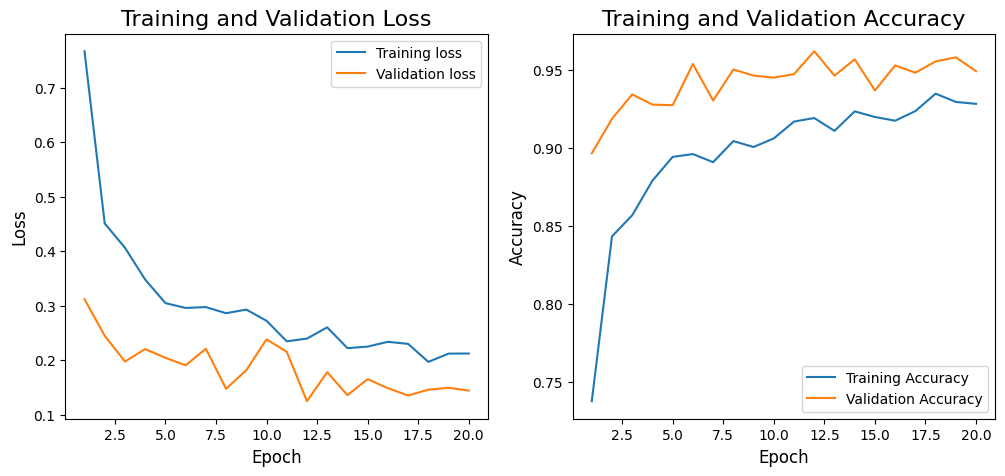

In [ ]:
#epoch_df = pd.read_csv('models/resnet_epoch25_pretrained_2fc.csv')

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epoch_df.Epoch, epoch_df.Train_Loss, label = 'Training loss')
plt.plot(epoch_df.Epoch, epoch_df.Val_Loss, label = 'Validation loss')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.title('Training and Validation Loss', fontsize=16)

plt.subplot(1,2,2)
plt.plot(epoch_df.Epoch, epoch_df.Train_Accuracy, label = 'Training Accuracy')
plt.plot(epoch_df.Epoch, epoch_df.Val_Accuracy, label = 'Validation Accuracy')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.title('Training and Validation Accuracy', fontsize=16)

### load the trained model

In [ ]:
model = resnet50_extended
if device.type == 'cpu':
    state_dict = torch.load('models/resnet_epoch25_pretrained_2fc.pth', map_location='cpu')
else:
    state_dict = torch.load('models/resnet_epoch25_pretrained_2fc.pth')
model.load_state_dict(state_dict)
for param in model.parameters():
    param.requires_grad=False

In [ ]:
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_data_eval = ImageFolderWithPaths(train_path, transform = test_transforms)
test_loader = torch.utils.data.DataLoader(test_data_eval, batch_size = BATCH_SIZE, sampler = test_sampler)
train_eval_loader = torch.utils.data.DataLoader(test_data_eval, batch_size = BATCH_SIZE, sampler = train_sampler)
val_eval_loader = torch.utils.data.DataLoader(test_data_eval, batch_size = BATCH_SIZE, sampler = val_sampler)
print('Number of images in testing set: {}'.format(len(test_loader.sampler)))
print('Number of images in train set: {}'.format(len(train_eval_loader.sampler)))
print('Number of images in val set: {}'.format(len(test_loader.sampler)))

Number of images in testing set: 750
Number of images in train set: 3500
Number of images in val set: 750


In [ ]:
criterion = nn.CrossEntropyLoss()
classes = test_data_eval.classes
summary_df, pred_df = model_eval_resnet50(test_loader, model, criterion, device, classes)

Test Loss: 0.151689

Test Accuracy (Overall): 94.400%  (708.0/750.0)

Test Accuracy of 01_TUMOR: 94.318% (83.0/88.0)
Test Accuracy of 02_STROMA: 95.122% (78.0/82.0)
Test Accuracy of 03_COMPLEX: 94.737% (90.0/95.0)
Test Accuracy of 04_LYMPHO: 81.915% (77.0/94.0)
Test Accuracy of 05_DEBRIS: 96.000% (96.0/100.0)
Test Accuracy of 06_MUCOSA: 96.875% (93.0/96.0)
Test Accuracy of 07_ADIPOSE: 96.907% (94.0/97.0)
Test Accuracy of 08_EMPTY: 98.980% (97.0/98.0)


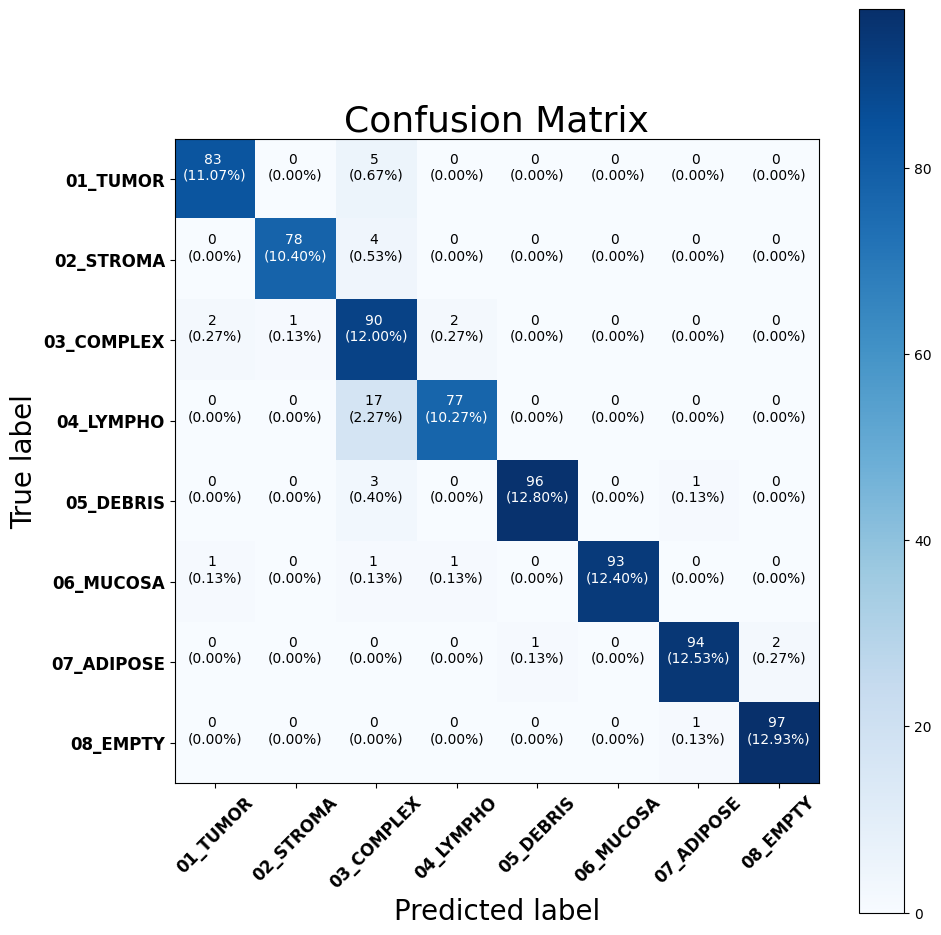

In [ ]:
cm = confusion_matrix(pred_df.true_label, pred_df.prediction)
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix')

## NEW trying this - resnet50, finetuned, 0.3 probability and 20 epochs - models/resnet_epoch25_pretrained_2fc_0.3p.pth

In [ ]:
resnet50_pretrained = models.resnet50(weights = models.ResNet50_Weights.DEFAULT)#models.ResNet50_Weights.DEFAULT
device = torch.device("cuda:0")
resnet50_pretrained = resnet50_pretrained.to(device)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
resnet50_pretrained

resnet50_pretrained = torch.nn.Sequential(*(list(resnet50_pretrained.children())[:-1]))

class MyResNet50(nn.Module):
    def __init__(self, pretrained_model):
        super(MyResNet50, self).__init__()
        self.pretrained = pretrained_model
        self.my_new_layer = nn.Sequential(nn.Linear(2048, 1024),
                                           nn.ReLU(inplace = True),
                                           nn.Dropout(p=0.3),
                                           nn.Linear(1024, 8))

    def forward(self, x):
        x = self.pretrained(x)
        # Flatten the tensor before passing to the first linear layer
        x = x.view(x.size(0), -1)
        x = self.my_new_layer(x)
        return x


resnet50_extended = MyResNet50(pretrained_model = resnet50_pretrained)
# resnet50_extended

# To make only classification layer learnable
# freezing the layers to only perform feature_extraction
#for param in resnet50_extended.parameters():
#    param.requires_grad=False

# for name, param in resnet50_extended.named_parameters() :
#     param.requires_grad = False
#     if name.startswith('my_new_layer') :
#         param.requires_grad = True

In [ ]:
# specify loss function
criterion = nn.CrossEntropyLoss()
# specify optimizer
optimizer = optim.Adam(resnet50_extended.parameters(), lr=0.0001)

In [ ]:
n_epochs = 20
save_path = 'models/resnet_epoch25_pretrained_2fc_0.3p.pth'
csv_path = 'models/resnet_epoch25_pretrained_2fc0.3p.csv'
resnet50_extended, epoch_df = train(n_epochs, train_loader, val_loader, resnet50_extended, criterion, optimizer, device, save_path, csv_path)

Epoch: 1/20..  Train Loss: 1.012..  Train Accuracy: 0.666..  Validation Loss: 0.321..  Validation Accuracy: 0.888
Validation loss decreased -- Saving model -- 

Epoch: 2/20..  Train Loss: 0.444..  Train Accuracy: 0.848..  Validation Loss: 0.231..  Validation Accuracy: 0.924
Validation loss decreased -- Saving model -- 

Epoch: 3/20..  Train Loss: 0.373..  Train Accuracy: 0.870..  Validation Loss: 0.274..  Validation Accuracy: 0.906
Epoch: 4/20..  Train Loss: 0.332..  Train Accuracy: 0.887..  Validation Loss: 0.222..  Validation Accuracy: 0.942
Validation loss decreased -- Saving model -- 

Epoch: 5/20..  Train Loss: 0.321..  Train Accuracy: 0.886..  Validation Loss: 0.248..  Validation Accuracy: 0.930
Epoch: 6/20..  Train Loss: 0.296..  Train Accuracy: 0.899..  Validation Loss: 0.164..  Validation Accuracy: 0.948
Validation loss decreased -- Saving model -- 

Epoch: 7/20..  Train Loss: 0.266..  Train Accuracy: 0.909..  Validation Loss: 0.159..  Validation Accuracy: 0.954
Validation los

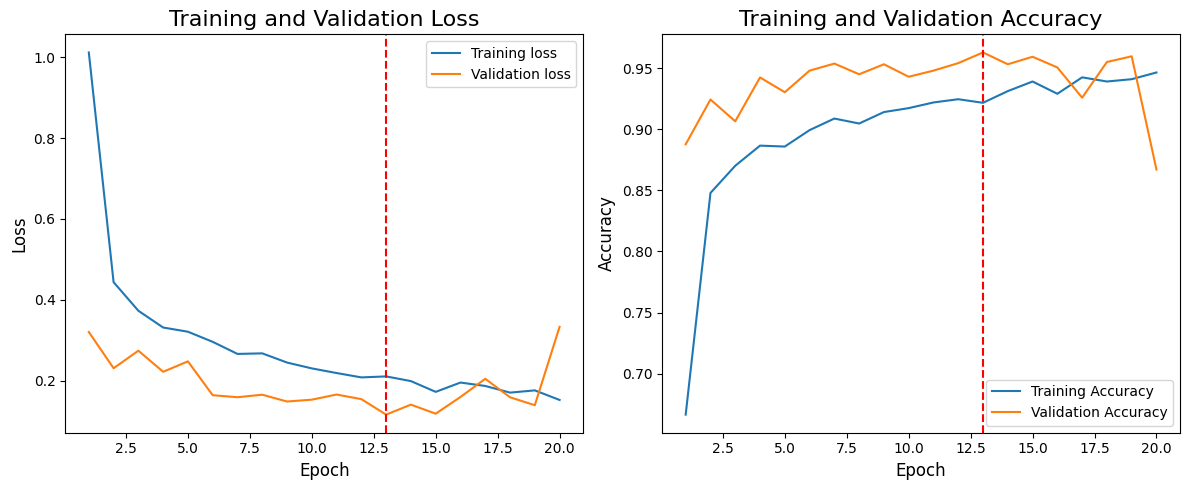

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epoch_df.Epoch, epoch_df.Train_Loss, label = 'Training loss')
plt.plot(epoch_df.Epoch, epoch_df.Val_Loss, label = 'Validation loss')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.title('Training and Validation Loss', fontsize=16)

plt.axvline(x=13, color='r', linestyle='--')  # add red vertical line at x=13

plt.subplot(1,2,2)
plt.plot(epoch_df.Epoch, epoch_df.Train_Accuracy, label = 'Training Accuracy')
plt.plot(epoch_df.Epoch, epoch_df.Val_Accuracy, label = 'Validation Accuracy')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.title('Training and Validation Accuracy', fontsize=16)

plt.axvline(x=13, color='r', linestyle='--')  # add red vertical line at x=13

plt.tight_layout()
plt.show()


In [ ]:
model = resnet50_extended
if device.type == 'cpu':
    state_dict = torch.load('models/resnet_epoch25_pretrained_2fc_0.3p.pth', map_location='cpu')
else:
    state_dict = torch.load('models/resnet_epoch25_pretrained_2fc_0.3p.pth')
model.load_state_dict(state_dict)
for param in model.parameters():
    param.requires_grad=False

In [ ]:
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_data_eval = ImageFolderWithPaths(train_path, transform = test_transforms)
test_loader = torch.utils.data.DataLoader(test_data_eval, batch_size = BATCH_SIZE, sampler = test_sampler)
train_eval_loader = torch.utils.data.DataLoader(test_data_eval, batch_size = BATCH_SIZE, sampler = train_sampler)
val_eval_loader = torch.utils.data.DataLoader(test_data_eval, batch_size = BATCH_SIZE, sampler = val_sampler)
print('Number of images in testing set: {}'.format(len(test_loader.sampler)))
print('Number of images in train set: {}'.format(len(train_eval_loader.sampler)))
print('Number of images in val set: {}'.format(len(test_loader.sampler)))

Number of images in testing set: 750
Number of images in train set: 3500
Number of images in val set: 750


In [ ]:
criterion = nn.CrossEntropyLoss()
classes = test_data_eval.classes
summary_df, pred_df = model_eval_resnet50(test_loader, model, criterion, device, classes)

Test Loss: 0.117231

Test Accuracy (Overall): 96.933%  (727.0/750.0)

Test Accuracy of 01_TUMOR: 96.591% (85.0/88.0)
Test Accuracy of 02_STROMA: 93.902% (77.0/82.0)
Test Accuracy of 03_COMPLEX: 95.789% (91.0/95.0)
Test Accuracy of 04_LYMPHO: 92.553% (87.0/94.0)
Test Accuracy of 05_DEBRIS: 98.000% (98.0/100.0)
Test Accuracy of 06_MUCOSA: 100.000% (96.0/96.0)
Test Accuracy of 07_ADIPOSE: 97.938% (95.0/97.0)
Test Accuracy of 08_EMPTY: 100.000% (98.0/98.0)


In [ ]:
print(classification_report(pred_df.true_label, pred_df.prediction))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98        88
           1       0.96      0.94      0.95        82
           2       0.88      0.96      0.92        95
           3       0.98      0.93      0.95        94
           4       0.98      0.98      0.98       100
           5       1.00      1.00      1.00        96
           6       0.99      0.98      0.98        97
           7       0.98      1.00      0.99        98

    accuracy                           0.97       750
   macro avg       0.97      0.97      0.97       750
weighted avg       0.97      0.97      0.97       750



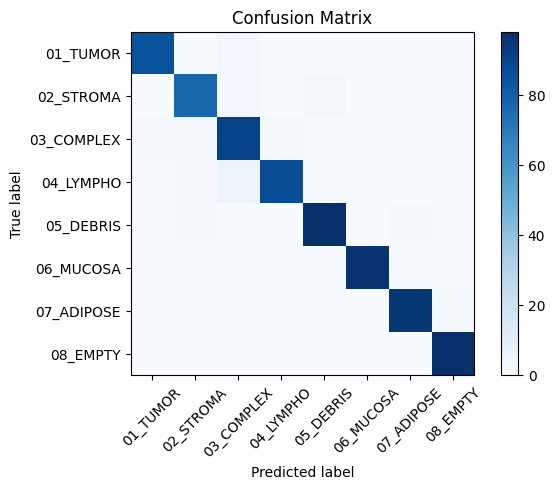

In [ ]:
cm = confusion_matrix(pred_df.true_label, pred_df.prediction)
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix')

In [ ]:
def plot_confusion_matrix(cm, classes, cmap=sns.color_palette("magma", as_cmap=True)):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title, fontsize=26)
    plt.colorbar(shrink=0.5)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=10)
    plt.yticks(tick_marks, classes, fontsize=10)

    for i in range(len(classes)):
        total = sum(cm[i])
        for j in range(len(classes)):
            if i == j:
                plt.text(j, i, '{:d} \n({:.1f}%)'.format(cm[i, j], cm[i, j] / total * 100),
                         horizontalalignment="center", color="black")
            else:
                plt.text(j, i, '{:d}'.format(cm[i, j]), horizontalalignment="center", color="white")

    plt.ylabel('True label', fontsize=15,fontweight='bold')
    plt.xlabel('Predicted label', fontsize=15 , fontweight='bold')
    plt.tight_layout()



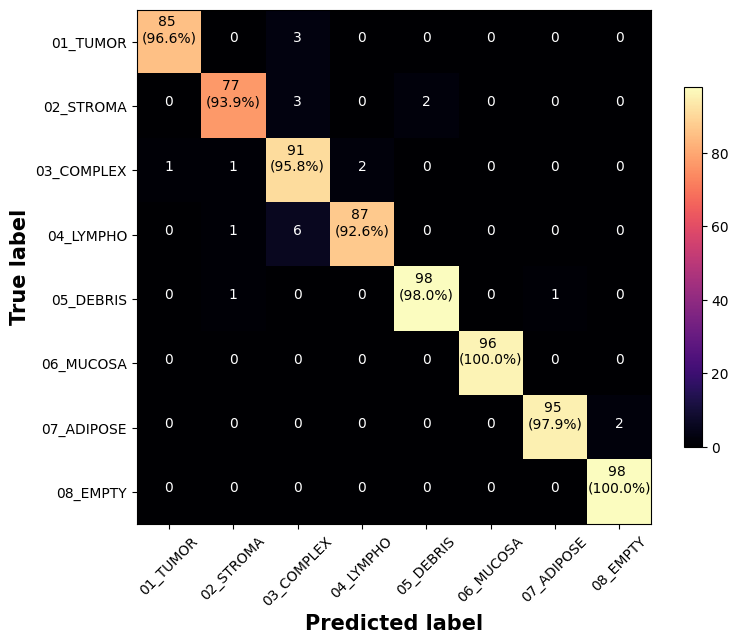

In [ ]:
cm = confusion_matrix(pred_df.true_label, pred_df.prediction)
plot_confusion_matrix(cm, classes)

Test Loss: 0.040817

Test Accuracy (Overall): 98.800%  (3458.0/3500.0)

Test Accuracy of 01_TUMOR: 100.000% (436.0/436.0)
Test Accuracy of 02_STROMA: 98.218% (441.0/449.0)
Test Accuracy of 03_COMPLEX: 97.229% (421.0/433.0)
Test Accuracy of 04_LYMPHO: 99.302% (427.0/430.0)
Test Accuracy of 05_DEBRIS: 99.775% (444.0/445.0)
Test Accuracy of 06_MUCOSA: 99.297% (424.0/427.0)
Test Accuracy of 07_ADIPOSE: 96.882% (435.0/449.0)
Test Accuracy of 08_EMPTY: 99.768% (430.0/431.0)


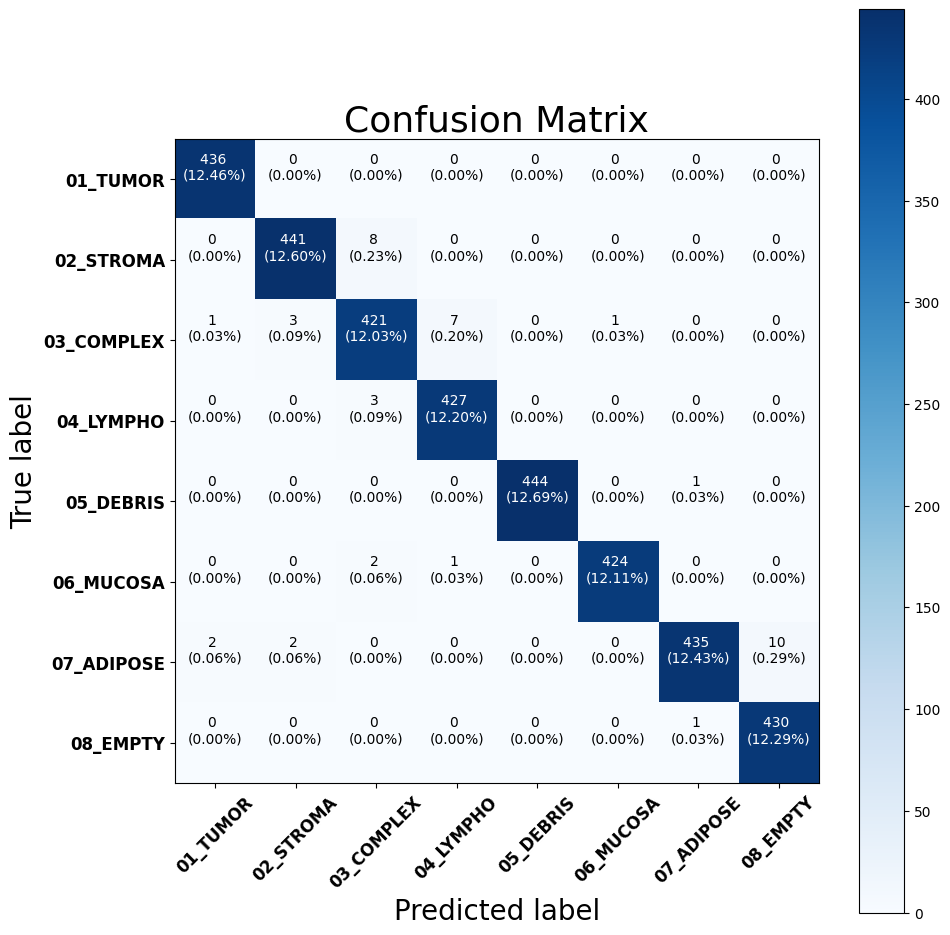

In [ ]:
criterion = nn.CrossEntropyLoss()
classes = test_data_eval.classes
summary_df, pred_df = model_eval_resnet50(train_eval_loader, model, criterion, device, classes)

cm = confusion_matrix(pred_df.true_label, pred_df.prediction)
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix')

### Improving fine tuned model using imagenet weights - reducing dropout prob from 0.3 to 0.2

In [ ]:
n_epochs = 20
save_path = 'models/resnet_epoch25_pretrained_dropout0.2_2fc.pth'
csv_path = 'models/resnet_epoch25_pretrained_dropout0.2_2fc.csv'
resnet50_extended, epoch_df = train(n_epochs, train_loader, val_loader, resnet50_extended, criterion, optimizer, device, save_path, csv_path)

Epoch: 1/20..  Train Loss: 1.010..  Train Accuracy: 0.651..  Validation Loss: 0.344..  Validation Accuracy: 0.885
Validation loss decreased -- Saving model -- 

Epoch: 2/20..  Train Loss: 0.443..  Train Accuracy: 0.851..  Validation Loss: 0.244..  Validation Accuracy: 0.913
Validation loss decreased -- Saving model -- 

Epoch: 3/20..  Train Loss: 0.376..  Train Accuracy: 0.871..  Validation Loss: 0.209..  Validation Accuracy: 0.924
Validation loss decreased -- Saving model -- 

Epoch: 4/20..  Train Loss: 0.343..  Train Accuracy: 0.885..  Validation Loss: 0.190..  Validation Accuracy: 0.936
Validation loss decreased -- Saving model -- 

Epoch: 5/20..  Train Loss: 0.301..  Train Accuracy: 0.894..  Validation Loss: 0.242..  Validation Accuracy: 0.929
Epoch: 6/20..  Train Loss: 0.266..  Train Accuracy: 0.911..  Validation Loss: 0.143..  Validation Accuracy: 0.954
Validation loss decreased -- Saving model -- 

Epoch: 7/20..  Train Loss: 0.266..  Train Accuracy: 0.904..  Validation Loss: 0.1

Text(0.5, 1.0, 'Training and Validation Accuracy')

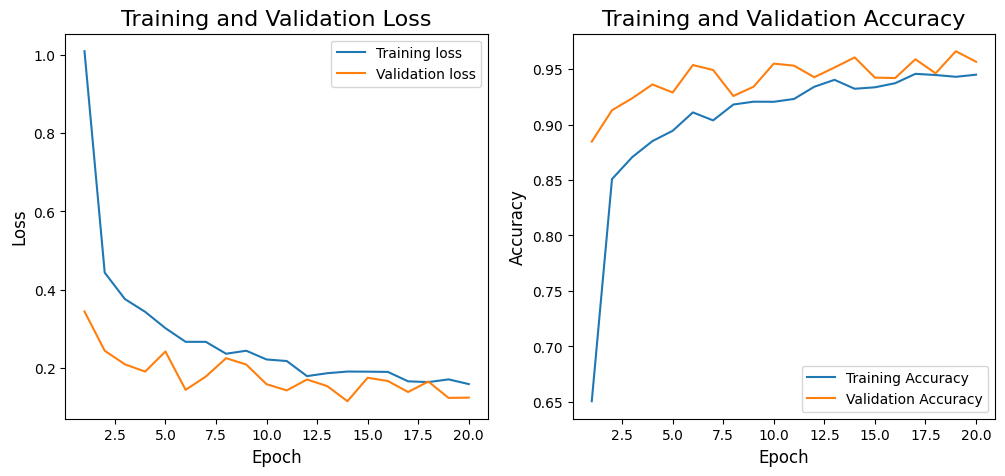

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epoch_df.Epoch, epoch_df.Train_Loss, label = 'Training loss')
plt.plot(epoch_df.Epoch, epoch_df.Val_Loss, label = 'Validation loss')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.title('Training and Validation Loss', fontsize=16)

plt.subplot(1,2,2)
plt.plot(epoch_df.Epoch, epoch_df.Train_Accuracy, label = 'Training Accuracy')
plt.plot(epoch_df.Epoch, epoch_df.Val_Accuracy, label = 'Validation Accuracy')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.title('Training and Validation Accuracy', fontsize=16)

In [ ]:
model = resnet50_extended
if device.type == 'cpu':
    state_dict = torch.load('models/resnet_epoch25_pretrained_dropout0.2_2fc.pth', map_location='cpu')
else:
    state_dict = torch.load('models/resnet_epoch25_pretrained_dropout0.2_2fc.pth')
model.load_state_dict(state_dict)
for param in model.parameters():
    param.requires_grad=False

In [ ]:
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    #transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_data_eval = ImageFolderWithPaths(train_path, transform = test_transforms)
test_loader = torch.utils.data.DataLoader(test_data_eval, batch_size = BATCH_SIZE, sampler = test_sampler)
train_eval_loader = torch.utils.data.DataLoader(test_data_eval, batch_size = BATCH_SIZE, sampler = train_sampler)
val_eval_loader = torch.utils.data.DataLoader(test_data_eval, batch_size = BATCH_SIZE, sampler = val_sampler)
print('Number of images in testing set: {}'.format(len(test_loader.sampler)))
print('Number of images in train set: {}'.format(len(train_eval_loader.sampler)))
print('Number of images in val set: {}'.format(len(test_loader.sampler)))

Number of images in testing set: 750
Number of images in train set: 3500
Number of images in val set: 750


In [ ]:
criterion = nn.CrossEntropyLoss()
classes = test_data_eval.classes
summary_df, pred_df = model_eval_resnet50(test_loader, model, criterion, device, classes)

Test Loss: 0.121424

Test Accuracy (Overall): 95.867%  (719.0/750.0)

Test Accuracy of 01_TUMOR: 96.591% (85.0/88.0)
Test Accuracy of 02_STROMA: 95.122% (78.0/82.0)
Test Accuracy of 03_COMPLEX: 93.684% (89.0/95.0)
Test Accuracy of 04_LYMPHO: 92.553% (87.0/94.0)
Test Accuracy of 05_DEBRIS: 97.000% (97.0/100.0)
Test Accuracy of 06_MUCOSA: 96.875% (93.0/96.0)
Test Accuracy of 07_ADIPOSE: 95.876% (93.0/97.0)
Test Accuracy of 08_EMPTY: 98.980% (97.0/98.0)


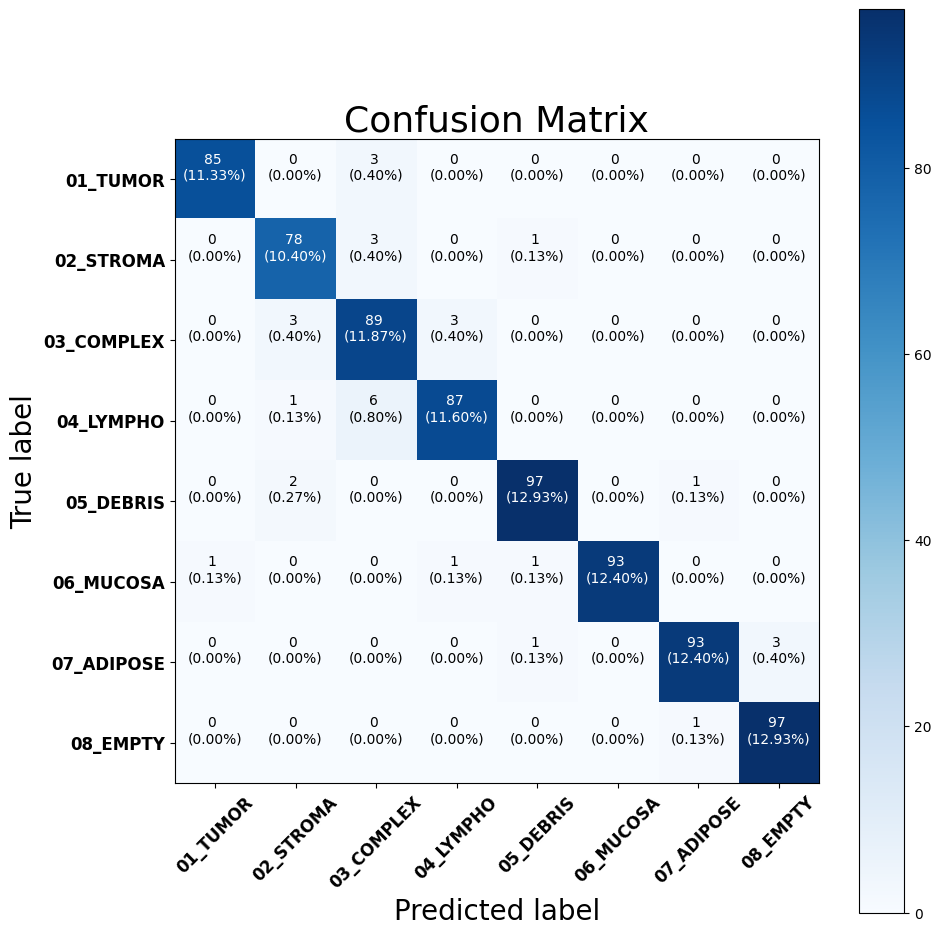

In [ ]:
cm = confusion_matrix(pred_df.true_label, pred_df.prediction)
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix')

## Getting class activation maps for best model - 0.3 dropout probability




In [ ]:
import numpy as np
import cv2
import argparse
from torchvision import models, transforms
from torch.nn import functional as F
from torch import topk

In [ ]:
# Functions
# Generate the CAM
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].reshape(-1, nc).T.dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

# Overlay CAM over original image
def show_cam(CAMs, width, height, orig_image, class_idx, all_classes):#, save_name):
    for i, cam in enumerate(CAMs):
        heatmap = cv2.applyColorMap(cv2.resize(cam,(width, height)), cv2.COLORMAP_JET)
        result = heatmap * 0.3 + orig_image * 0.5
        # put class label text on the result
        cv2.putText(result, "", (20, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 2)
        plt.imshow(result/255.)
        cv2.waitKey(0)
        #cv2.imwrite(f"outputs/CAM_{save_name}.jpg", result)


# def load_synset_classes(file_path):
#     # load the synset text file for labels
#     all_classes = []
#     with open(file_path, 'r') as f:
#         all_lines = f.readlines()
#         labels = [line.split('\n') for line in all_lines]
#         for label_list in labels:
#             current_class = [name.split(',') for name in label_list][0][0][10:]
#             all_classes.append(current_class)
#     return all_classes
# # get all the classes in a list
# all_classes = load_synset_classes('/content/drive/MyDrive/colorectal_images/Kath



In [ ]:
# read and visualize the image
image = cv2.imread(total_files[0])
orig_image = image.copy()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
height, width, _ = image.shape

In [ ]:
# load the model
model = models.resnet50(pretrained=True).eval()
model
# hook the feature extractor
# https://github.com/zhoubolei/CAM/blob/master/pytorch_CAM.py
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())
model._modules.get('layer4').register_forward_hook(hook_feature)
# get the softmax weight
params = list(model.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
len(features_blobs)

0

In [ ]:
# define the transforms, resize => tensor => normalize
transforms = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    ])

In [ ]:
# apply the image transforms
image_tensor = transforms(image)
# add batch dimension
image_tensor = image_tensor.unsqueeze(0)
# forward pass through model
outputs = model(image_tensor)
# get the softmax probabilities
probs = F.softmax(outputs).data.squeeze()
# get the class indices of top k probabilities
class_idx = topk(probs, 1)[1].int()

<ipython-input-61-a7c13625d1f5>:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(outputs).data.squeeze()


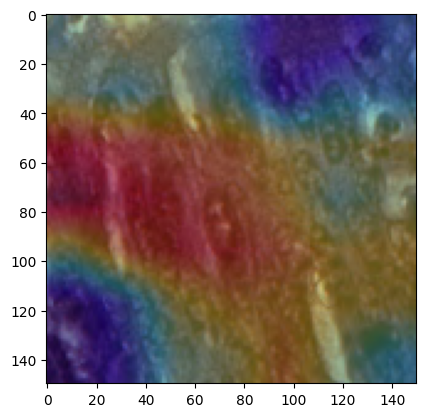

In [ ]:
# generate class activation mapping for the top1 prediction
CAMs = returnCAM(features_blobs[0], weight_softmax, class_idx)
# file name to save the resulting CAM image with
save_name = "01_TUMOR"
# show and save the results
show_cam(CAMs, width, height, orig_image, class_idx, gt_labels)

In [ ]:
features_blobs[0].shape

(1, 2048, 1, 1)

In [ ]:
model = resnet50_extended
if device.type == 'cpu':
    state_dict = torch.load('models/resnet_epoch25_pretrained_2fc_0.3p.pth', map_location='cpu')
else:
    state_dict = torch.load('models/resnet_epoch25_pretrained_2fc_0.3p.pth')
model.load_state_dict(state_dict)
for param in model.parameters():
    param.requires_grad=False
# hook the feature extractor
# https://github.com/zhoubolei/CAM/blob/master/pytorch_CAM.py
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())
model.eval()._modules.get('pretrained').register_forward_hook(hook_feature)
# get the softmax weight
params = list(model.parameters())
weight_softmax = np.squeeze(params[-2].data.cpu().numpy())

In [ ]:
len(features_blobs)


0

In [ ]:
# read and visualize the image
image = cv2.imread(total_files[0])
orig_image = image.copy()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
height, width, _ = image.shape

In [ ]:
# define the transforms, resize => tensor => normalize
transforms = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    ])

In [ ]:
# apply the image transforms
image_tensor = transforms(image)
# add batch dimension
image_tensor = image_tensor.unsqueeze(0)
image_tensor = image_tensor.to(device)
# forward pass through model
outputs = model(image_tensor)
# get the softmax probabilities
probs = F.softmax(outputs).data.squeeze()
# get the class indices of top k probabilities
class_idx = topk(probs, 1)[1].int()

<ipython-input-81-079f26d036fd>:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(outputs).data.squeeze()


In [ ]:
print(weight_softmax.shape)
print(features_blobs[0].shape)

(8, 1024)
(1, 2048, 1, 1)


In [ ]:
# generate class activation mapping for the top1 prediction
CAMs = returnCAM(features_blobs[0], weight_softmax, class_idx)
# file name to save the resulting CAM image with
save_name = "01_TUMOR"
# show and save the results
show_cam(CAMs, width, height, orig_image, class_idx, gt_labels)

ValueError: ignored

In [ ]:
np.argmax(class_idx.detach())

tensor(0)

In [ ]:
# Getting ResNet50 trained model ready

# load the model
model = models.resnet50(pretrained=True).eval()
# hook the feature extractor
# https://github.com/zhoubolei/CAM/blob/master/pytorch_CAM.py
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())
model._modules.get('layer4').register_forward_hook(hook_feature)
# get the softmax weight
params = list(model.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())



# Best ResNet50 parameters fined-tuned on ImageNet with different classification method (stacked learner)

In [ ]:
# Define preprocessing
preprocess = transforms.Compose([
  transforms.ToPILImage(),
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Apply preprocess
image_tensor = torch.stack([preprocess(image) for image in data])
image_tensor.shape

torch.Size([5000, 3, 224, 224])

In [ ]:
resnet50_pretrained = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)#models.ResNet50_Weights.DEFAULT
device = torch.device("cuda:0")
resnet50_pretrained = resnet50_pretrained.to(device)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
# resnet50_pretrained

resnet50_pretrained = torch.nn.Sequential(*(list(resnet50_pretrained.children())[:-1]))

# might use if i want the class activation map
class MyResNet50(nn.Module):
    def __init__(self, pretrained_model):
        super(MyResNet50, self).__init__()
        self.pretrained = pretrained_model
        # self.my_new_layer = nn.Sequential(nn.Linear(2048, 1024),
        #                                    nn.ReLU(inplace = True),
        #                                    nn.Dropout(p=0.3),
        #                                    nn.Linear(1024, 8))

    def forward(self, x):
        x = self.pretrained(x)
        # Flatten the tensor before passing to the first linear layer
        x = x.view(x.size(0), -1)
        # x = self.my_new_layer(x)
        return x

    def get_activations(self, x):
        x = self.pretrained(x)
        # Flatten the tensor before passing to the first linear layer
        x = x.view(x.size(0), -1)
        # x = self.my_new_layer[:-1](x)
        return x

    def get_activations_gradient(self):
        return self.my_new_layer[-1].weight.grad


resnet50_featextract = MyResNet50(pretrained_model = resnet50_pretrained)
# resnet50_extended

# To make only classification layer learnable
# freezing the layers to only perform feature_extraction
#for param in resnet50_extended.parameters():
#    param.requires_grad=False

# for name, param in resnet50_extended.named_parameters() :
#     param.requires_grad = False
#     if name.startswith('my_new_layer') :
#         param.requires_grad = True

resnet50_featextract.eval()

MyResNet50(
  (pretrained): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2

## Using ResNet50 to extract features for SVM

In [ ]:
# result = torch.empty((len(image_tensor), 2048), device=device)
# for i, data in enumerate(image_tensor):
#   output = resnet50_featextract(data.unsqueeze(0).to(device))
#   output = torch.flatten(output, 1)
#   result[i] = output[0]

batch_size = 16
result = np.empty((len(image_tensor), 2048))
for i in range(0, len(image_tensor), batch_size):
  data = image_tensor[i:i+batch_size].to(device)
  output = resnet50_featextract(data)
  output = torch.flatten(output, 1)
  result[i:i+batch_size] = output.detach().cpu().numpy()


In [ ]:
result.shape

(5000, 2048)

In [ ]:
total_num = 5000
split1 = int(total_num*0.7) # split of 0.7, 0.15, 0.15
split2 = int(total_num*0.85)
indices = np.arange(total_num)

np.random.seed(123)
np.random.shuffle(indices)
train_idx, val_idx, test_idx = indices[:split1], indices[split1:split2], indices[split2:]

X, y = result, np.array(gt_labels)

X_train = X[train_idx]
Y_train = y[train_idx]
X_val = X[val_idx]
Y_val = y[val_idx]
X_test = X[test_idx]
Y_test = y[test_idx]

print("train breakdown ", np.bincount(Y_train))
print("val breakdown ", np.bincount(Y_val))
print("test breakdown ", np.bincount(Y_test))



train breakdown  [436 449 433 430 445 427 449 431]
val breakdown  [101  94  97 101  80 102  79  96]
test breakdown  [ 88  82  95  94 100  96  97  98]


In [ ]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

clf = StackingClassifier(
    estimators=[('svm', SVC(random_state=42)),
                ('ensemble', RandomForestClassifier(random_state=42))],
    final_estimator=LogisticRegression(random_state=42, max_iter=2000),
    n_jobs=-1)

clf.fit(X_train, Y_train)

StackingClassifier(estimators=[('svm', SVC(random_state=42)),
                               ('ensemble',
                                RandomForestClassifier(random_state=42))],
                   final_estimator=LogisticRegression(max_iter=2000,
                                                      random_state=42),
                   n_jobs=-1)

Accuracy score :  0.9253333333333333
Precision score :  0.9257083506164636
Recall score :  0.9253333333333333
F1 score :  0.9254676461569461


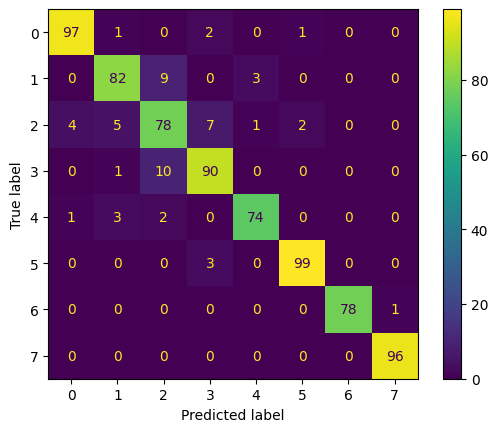

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

y_pred = clf.predict(X_val)

print('Accuracy score : ', accuracy_score(Y_val, y_pred))
print('Precision score : ', precision_score(Y_val, y_pred, average='weighted'))
print('Recall score : ', recall_score(Y_val, y_pred, average='weighted'))
print('F1 score : ', f1_score(Y_val, y_pred, average='weighted'))

confusion_matrix = confusion_matrix(Y_val, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix)
disp.plot()
plt.show()

In [ ]:
print(classification_report(Y_val, y_pred))

accuracy_all = confusion_matrix.diagonal()/confusion_matrix.sum(axis=1)

for subset in accuracy_all:
    print(subset)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       101
           1       0.89      0.88      0.89        94
           2       0.79      0.80      0.80        97
           3       0.88      0.89      0.89       101
           4       0.96      0.93      0.94        80
           5       0.96      0.97      0.97       102
           6       1.00      0.99      0.99        79
           7       0.99      1.00      0.99        96

    accuracy                           0.93       750
   macro avg       0.93      0.93      0.93       750
weighted avg       0.93      0.93      0.93       750

0.9504950495049505
0.8829787234042553
0.8041237113402062
0.8910891089108911
0.925
0.9705882352941176
0.9873417721518988
1.0


## Grid search for optimal parameters

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

param_grid = {
    'svm__C': [1.6, 1.7, 1.9],
    'svm__kernel': ['rbf'],
    'svm__gamma': ['auto', 'scale'],
    'ensemble__criterion': ['entropy'],
    'ensemble__n_estimators' : [1000, 2000, 3000, 4000, 5000],
    #'tree__max_depth': [8, 11, 14],
    #'final_estimator__C': [1.3, 1.4, 1.5]
}

scorer = make_scorer(f1_score, average = 'weighted')

grid = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring=scorer)

grid.fit(X_val, Y_val)

print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

Best parameters: {'ensemble__criterion': 'entropy', 'ensemble__n_estimators': 3000, 'svm__C': 1.9, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Accuracy: 0.88


In [ ]:
print(list(range(1000, 5001, 500)))

[1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]


In [ ]:
clf_predict = StackingClassifier(
    estimators=[('svm', SVC(random_state=42, kernel = "rbf", C = 1.9, gamma="scale")),
                ('ensemble', RandomForestClassifier(random_state=42, criterion = "entropy", n_estimators=3000))],
    final_estimator=LogisticRegression(random_state=42, max_iter=2000),
    n_jobs=-1)

clf_predict.fit(X_train, Y_train)

StackingClassifier(estimators=[('svm', SVC(C=1.9, random_state=42)),
                               ('ensemble',
                                RandomForestClassifier(criterion='entropy',
                                                       n_estimators=3000,
                                                       random_state=42))],
                   final_estimator=LogisticRegression(max_iter=2000,
                                                      random_state=42),
                   n_jobs=-1)

Accuracy score :  0.9937142857142857
Precision score :  0.9937530826378099
Recall score :  0.9937142857142857
F1 score :  0.9937165942343584


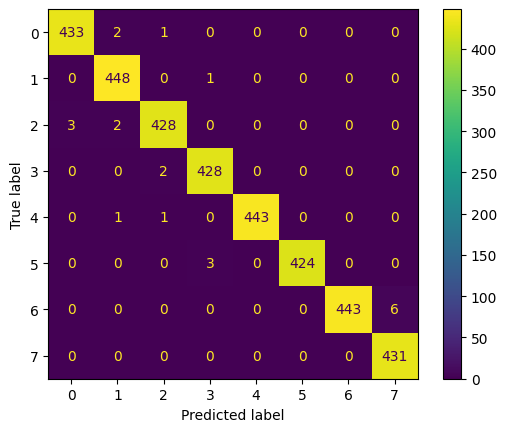

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

y_pred = clf_predict.predict(X_train)

print('Accuracy score : ', accuracy_score(Y_train, y_pred))
print('Precision score : ', precision_score(Y_train, y_pred, average='weighted'))
print('Recall score : ', recall_score(Y_train, y_pred, average='weighted'))
print('F1 score : ', f1_score(Y_train, y_pred, average='weighted'))

confusion_matrix = confusion_matrix(Y_train, y_pred, labels=clf_predict.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix)
disp.plot()
plt.show()

Accuracy score :  0.94
Precision score :  0.9404703799372522
Recall score :  0.94
F1 score :  0.9401695578933092


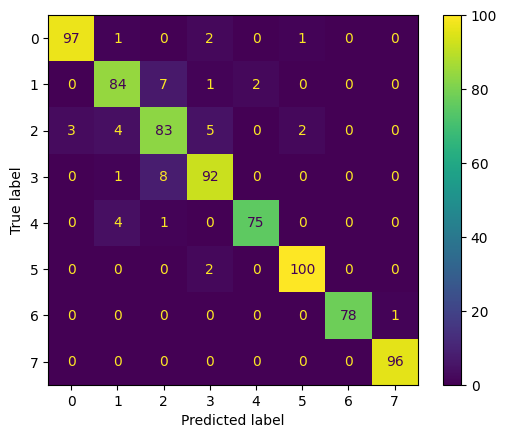

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

y_pred = clf_predict.predict(X_val)

print('Accuracy score : ', accuracy_score(Y_val, y_pred))
print('Precision score : ', precision_score(Y_val, y_pred, average='weighted'))
print('Recall score : ', recall_score(Y_val, y_pred, average='weighted'))
print('F1 score : ', f1_score(Y_val, y_pred, average='weighted'))

confusion_matrix = confusion_matrix(Y_val, y_pred, labels=clf_predict.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix)
disp.plot()
plt.show()

In [ ]:
print(classification_report(Y_val, y_pred))

accuracy_all = confusion_matrix.diagonal()/confusion_matrix.sum(axis=1)

for subset in accuracy_all:
    print(subset)

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       101
           1       0.89      0.89      0.89        94
           2       0.84      0.86      0.85        97
           3       0.90      0.91      0.91       101
           4       0.97      0.94      0.96        80
           5       0.97      0.98      0.98       102
           6       1.00      0.99      0.99        79
           7       0.99      1.00      0.99        96

    accuracy                           0.94       750
   macro avg       0.94      0.94      0.94       750
weighted avg       0.94      0.94      0.94       750

0.9603960396039604
0.8936170212765957
0.8556701030927835
0.9108910891089109
0.9375
0.9803921568627451
0.9873417721518988
1.0


## Performance on test set

Accuracy score :  0.9466666666666667
Precision score :  0.9469137355847455
Recall score :  0.9466666666666667
F1 score :  0.9466023211219733


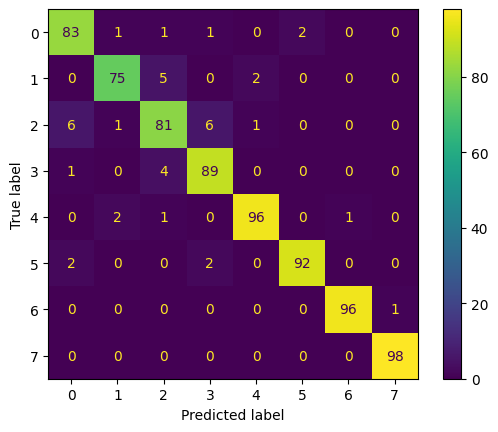

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

y_pred = clf_predict.predict(X_test)

print('Accuracy score : ', accuracy_score(Y_test, y_pred))
print('Precision score : ', precision_score(Y_test, y_pred, average='weighted'))
print('Recall score : ', recall_score(Y_test, y_pred, average='weighted'))
print('F1 score : ', f1_score(Y_test, y_pred, average='weighted'))

confusion_matrix = confusion_matrix(Y_test, y_pred, labels=clf_predict.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix)
disp.plot()
plt.show()

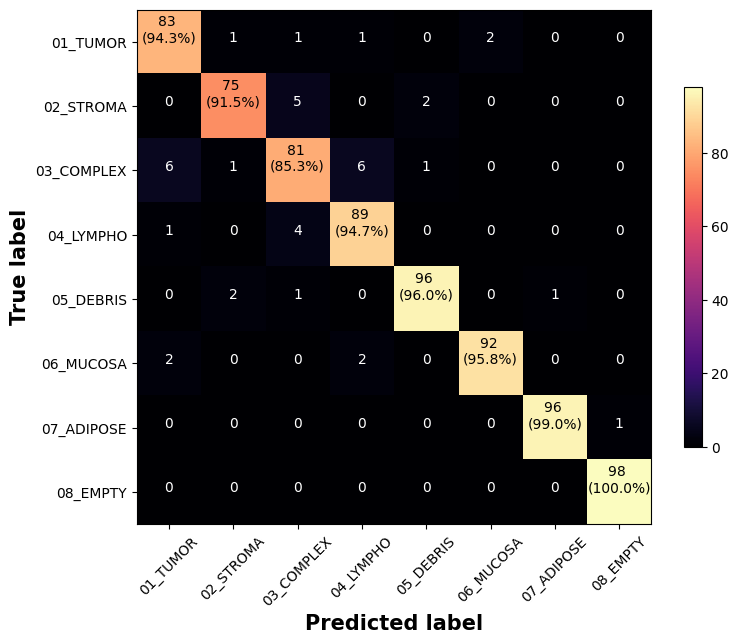

In [ ]:
plot_confusion_matrix(confusion_matrix, classes)

In [ ]:
def plot_confusion_matrix(cm, classes, cmap=sns.color_palette("magma", as_cmap=True)):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title, fontsize=26)
    plt.colorbar(shrink=0.5)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=10)
    plt.yticks(tick_marks, classes, fontsize=10)

    for i in range(len(classes)):
        total = sum(cm[i])
        for j in range(len(classes)):
            if i == j:
                plt.text(j, i, '{:d} \n({:.1f}%)'.format(cm[i, j], cm[i, j] / total * 100),
                         horizontalalignment="center", color="black")
            else:
                plt.text(j, i, '{:d}'.format(cm[i, j]), horizontalalignment="center", color="white")

    plt.ylabel('True label', fontsize=15,fontweight='bold')
    plt.xlabel('Predicted label', fontsize=15 , fontweight='bold')
    plt.tight_layout()



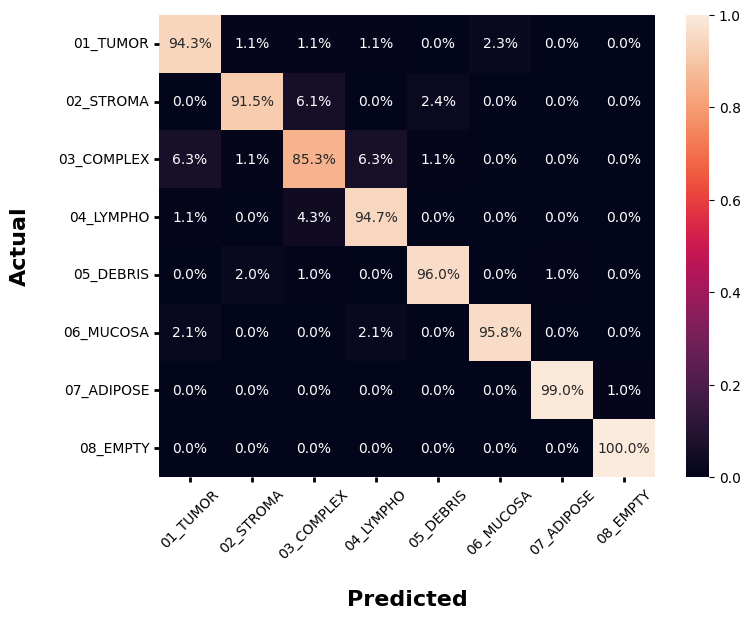

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(Y_test, y_pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(8,6)) # <-- reduce figsize from (10,10) to (8,8)
sns.heatmap(cmn, annot=True, fmt='.1%', xticklabels=img_labels, yticklabels=img_labels, ax=ax)
ax.tick_params(axis='both', which='major', labelsize=10, width=2)
ax.set_ylabel('Actual', fontsize=16, fontweight='bold', labelpad=20)
ax.set_xlabel('Predicted', fontsize=16, fontweight='bold', labelpad=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.show(block=False)


In [ ]:
print(classification_report(Y_test, y_pred))

accuracy_all = confusion_matrix.diagonal()/confusion_matrix.sum(axis=1)

for subset in accuracy_all:
    print(subset)

              precision    recall  f1-score   support

           0       0.90      0.94      0.92        88
           1       0.95      0.91      0.93        82
           2       0.88      0.85      0.87        95
           3       0.91      0.95      0.93        94
           4       0.97      0.96      0.96       100
           5       0.98      0.96      0.97        96
           6       0.99      0.99      0.99        97
           7       0.99      1.00      0.99        98

    accuracy                           0.95       750
   macro avg       0.95      0.95      0.95       750
weighted avg       0.95      0.95      0.95       750

0.9431818181818182
0.9146341463414634
0.8526315789473684
0.9468085106382979
0.96
0.9583333333333334
0.9896907216494846
1.0


# Using best ResNet50 trained on this data with stacked learner

In [ ]:
model = resnet50_extended
if device.type == 'cpu':
    state_dict = torch.load('models/resnet_epoch25_pretrained_2fc_0.3p.pth', map_location='cpu')
else:
    state_dict = torch.load('models/resnet_epoch25_pretrained_2fc_0.3p.pth')
model.load_state_dict(state_dict)
for param in model.parameters():
    param.requires_grad=False

In [ ]:
# resnet50_pretrained = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)#models.ResNet50_Weights.DEFAULT
# device = torch.device("cuda:0")
# resnet50_pretrained = resnet50_pretrained.to(device)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
# resnet50_pretrained

resnet50_pretrained = torch.nn.Sequential(*(list(model.children())[:-1]))

# might use if i want the class activation map
class MyResNet50(nn.Module):
    def __init__(self, pretrained_model):
        super(MyResNet50, self).__init__()
        self.pretrained = pretrained_model
        # self.my_new_layer = nn.Sequential(nn.Linear(2048, 1024),
        #                                    nn.ReLU(inplace = True),
        #                                    nn.Dropout(p=0.3),
        #                                    nn.Linear(1024, 8))

    def forward(self, x):
        x = self.pretrained(x)
        # Flatten the tensor before passing to the first linear layer
        x = x.view(x.size(0), -1)
        # x = self.my_new_layer(x)
        return x

    def get_activations(self, x):
        x = self.pretrained(x)
        # Flatten the tensor before passing to the first linear layer
        x = x.view(x.size(0), -1)
        # x = self.my_new_layer[:-1](x)
        return x

    def get_activations_gradient(self):
        return self.my_new_layer[-1].weight.grad


resnet50_featextract = MyResNet50(pretrained_model = resnet50_pretrained)
# resnet50_extended

# To make only classification layer learnable
# freezing the layers to only perform feature_extraction
#for param in resnet50_extended.parameters():
#    param.requires_grad=False

# for name, param in resnet50_extended.named_parameters() :
#     param.requires_grad = False
#     if name.startswith('my_new_layer') :
#         param.requires_grad = True

resnet50_featextract.eval()

MyResNet50(
  (pretrained): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
       

In [ ]:
# Define preprocessing
preprocess = transforms.Compose([
  transforms.ToPILImage(),
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Apply preprocess
image_tensor = torch.stack([preprocess(image) for image in data])
image_tensor.shape

torch.Size([5000, 3, 224, 224])

## Using ResNet50 to extract features

In [ ]:
# result = torch.empty((len(image_tensor), 2048), device=device)
# for i, data in enumerate(image_tensor):
#   output = resnet50_featextract(data.unsqueeze(0).to(device))
#   output = torch.flatten(output, 1)
#   result[i] = output[0]

batch_size = 16
result = np.empty((len(image_tensor), 2048))
for i in range(0, len(image_tensor), batch_size):
  data = image_tensor[i:i+batch_size].to(device)
  output = resnet50_featextract(data)
  output = torch.flatten(output, 1)
  result[i:i+batch_size] = output.detach().cpu().numpy()

In [ ]:
total_num = 5000
split1 = int(total_num*0.7) # split of 0.7, 0.15, 0.15
split2 = int(total_num*0.85)
indices = np.arange(total_num)

np.random.seed(123)
np.random.shuffle(indices)
train_idx, val_idx, test_idx = indices[:split1], indices[split1:split2], indices[split2:]

X, y = result, np.array(gt_labels)

X_train = X[train_idx]
Y_train = y[train_idx]
X_val = X[val_idx]
Y_val = y[val_idx]
X_test = X[test_idx]
Y_test = y[test_idx]

print("train breakdown ", np.bincount(Y_train))
print("val breakdown ", np.bincount(Y_val))
print("test breakdown ", np.bincount(Y_test))



train breakdown  [436 449 433 430 445 427 449 431]
val breakdown  [101  94  97 101  80 102  79  96]
test breakdown  [ 88  82  95  94 100  96  97  98]


## Grid search for last stacked learner

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

param_grid = {
    'svm__C': [1.6, 1.7, 1.9],
    'svm__kernel': ['rbf'],
    'svm__gamma': ['auto', 'scale'],
    'ensemble__criterion': ['entropy'],
    'ensemble__n_estimators' : [1000, 2000, 3000, 4000, 5000],
    #'tree__max_depth': [8, 11, 14],
    #'final_estimator__C': [1.3, 1.4, 1.5]
}

scorer = make_scorer(f1_score, average = 'weighted')

grid = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring=scorer)

grid.fit(X_val, Y_val)

print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

Best parameters: {'ensemble__criterion': 'entropy', 'ensemble__n_estimators': 1000, 'svm__C': 1.6, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Accuracy: 0.97


In [ ]:
clf_predict = StackingClassifier(
    estimators=[('svm', SVC(random_state=42, kernel = "rbf", C = 1.6, gamma="scale")),
                ('ensemble', RandomForestClassifier(random_state=42, criterion = "entropy", n_estimators=1000))],
    final_estimator=LogisticRegression(random_state=42, max_iter=2000),
    n_jobs=-1)

clf_predict.fit(X_train, Y_train)

StackingClassifier(estimators=[('svm', SVC(C=1.6, random_state=42)),
                               ('ensemble',
                                RandomForestClassifier(criterion='entropy',
                                                       n_estimators=1000,
                                                       random_state=42))],
                   final_estimator=LogisticRegression(max_iter=2000,
                                                      random_state=42),
                   n_jobs=-1)

Accuracy score :  0.9971428571428571
Precision score :  0.9971519898126348
Recall score :  0.9971428571428571
F1 score :  0.9971448266522699


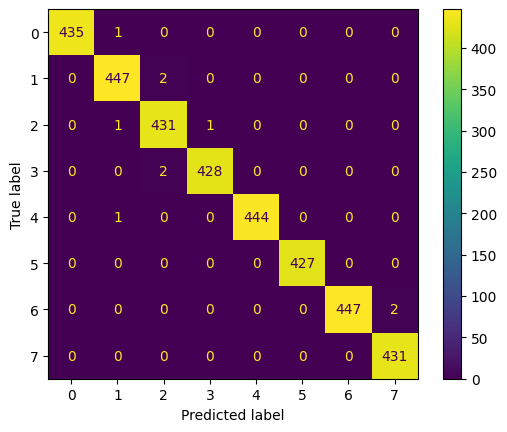

In [ ]:
# prediction on train using grid search params
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

y_pred = clf_predict.predict(X_train)

print('Accuracy score : ', accuracy_score(Y_train, y_pred))
print('Precision score : ', precision_score(Y_train, y_pred, average='weighted'))
print('Recall score : ', recall_score(Y_train, y_pred, average='weighted'))
print('F1 score : ', f1_score(Y_train, y_pred, average='weighted'))

confusion_matrix = confusion_matrix(Y_train, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix)
disp.plot()
plt.show()

Accuracy score :  0.9853333333333333
Precision score :  0.9855217248553796
Recall score :  0.9853333333333333
F1 score :  0.9853655381837648


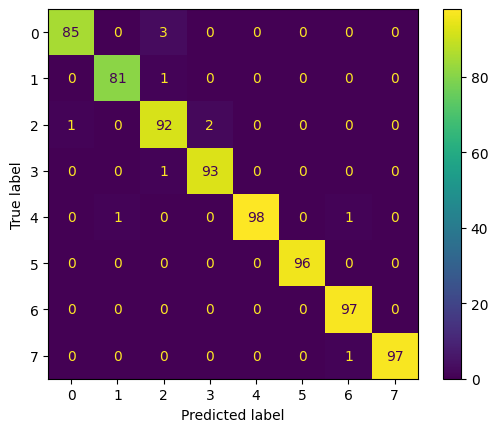

In [ ]:
# prediction on test
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

y_pred = clf_predict.predict(X_test)

print('Accuracy score : ', accuracy_score(Y_test, y_pred))
print('Precision score : ', precision_score(Y_test, y_pred, average='weighted'))
print('Recall score : ', recall_score(Y_test, y_pred, average='weighted'))
print('F1 score : ', f1_score(Y_test, y_pred, average='weighted'))

confusion_matrix = confusion_matrix(Y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix)
disp.plot()
plt.show()

## Trying the stacked learner with grid search parameters from model 2

In [ ]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

clf = StackingClassifier(
    estimators=[('svm', SVC(random_state=42)),
                ('ensemble', RandomForestClassifier(random_state=42))],
    final_estimator=LogisticRegression(random_state=42, max_iter=2000),
    n_jobs=-1)

#clf.fit(X_train, Y_train)

clf_predict = StackingClassifier(
    estimators=[('svm', SVC(random_state=42, kernel = "rbf", C = 1.9, gamma="scale")),
                ('ensemble', RandomForestClassifier(random_state=42, criterion = "entropy", n_estimators=3000))],
    final_estimator=LogisticRegression(random_state=42, max_iter=2000),
    n_jobs=-1)

clf_predict.fit(X_train, Y_train)

StackingClassifier(estimators=[('svm', SVC(C=1.9, random_state=42)),
                               ('ensemble',
                                RandomForestClassifier(criterion='entropy',
                                                       n_estimators=3000,
                                                       random_state=42))],
                   final_estimator=LogisticRegression(max_iter=2000,
                                                      random_state=42),
                   n_jobs=-1)

Accuracy score :  0.9773333333333334
Precision score :  0.9778009442677416
Recall score :  0.9773333333333334
F1 score :  0.9773711203471548


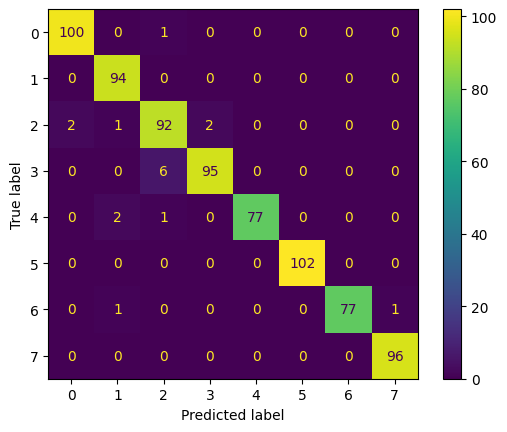

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

y_pred = clf_predict.predict(X_val)

print('Accuracy score : ', accuracy_score(Y_val, y_pred))
print('Precision score : ', precision_score(Y_val, y_pred, average='weighted'))
print('Recall score : ', recall_score(Y_val, y_pred, average='weighted'))
print('F1 score : ', f1_score(Y_val, y_pred, average='weighted'))

confusion_matrix = confusion_matrix(Y_val, y_pred, labels=clf_predict.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix)
disp.plot()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np

y_pred = clf_predict.predict(X_val)

print('Accuracy score : ', accuracy_score(Y_val, y_pred))
print('Precision score : ', precision_score(Y_val, y_pred, average='weighted'))
print('Recall score : ', recall_score(Y_val, y_pred, average='weighted'))
print('F1 score : ', f1_score(Y_val, y_pred, average='weighted'))

conf_mat = confusion_matrix(Y_val, y_pred, labels=clf_predict.classes_)
disp = ConfusionMatrixDisplay(conf_mat)

# modify the plot method to annotate each cell with diagonal percentage value
def plot_confusion_matrix_with_diag_perc(disp, **kwargs):
    disp.ax.set_xticks(np.arange(disp.confusion_matrix.shape[1]))
    disp.ax.set_yticks(np.arange(disp.confusion_matrix.shape[0]))
    for i in range(disp.confusion_matrix.shape[0]):
        for j in range(disp.confusion_matrix.shape[1]):
            cell_text = format(disp.confusion_matrix[i, j], '.0f')
            if i == j:
                cell_text += '\n' + format(np.diag(disp.confusion_matrix)[i] / np.sum(disp.confusion_matrix, axis=1)[i] * 100, '.1f') + '%'
            disp.ax.text(j, i, cell_text, ha='center', va='center',
                          color='white' if disp.confusion_matrix[i, j] > np.sum(disp.confusion_matrix, axis=1)[i] / len(disp.confusion_matrix) else 'black')
    disp.ax.set_xticklabels(disp.display_labels)
    disp.ax.set_yticklabels(disp.display_labels, va='center')
    disp.ax.set_xlabel(disp.xlabel)
    disp.ax.set_ylabel(disp.ylabel)

disp.plot = plot_confusion_matrix_with_diag_perc.__get__(disp, ConfusionMatrixDisplay)
disp.plot()
plt.show()


Accuracy score :  0.9773333333333334
Precision score :  0.9778009442677416
Recall score :  0.9773333333333334
F1 score :  0.9773711203471548


AttributeError: ignored

## Performance on test set

Accuracy score :  0.9853333333333333
Precision score :  0.9855217248553796
Recall score :  0.9853333333333333
F1 score :  0.9853655381837648


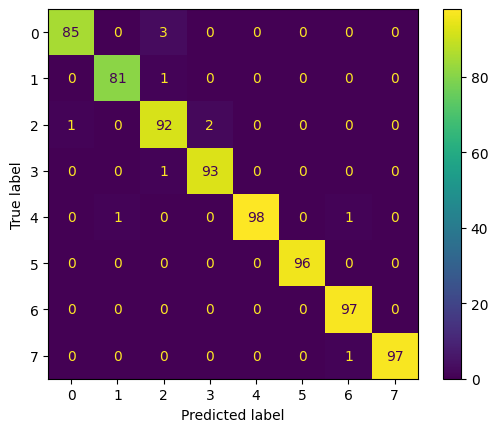

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

y_pred = clf_predict.predict(X_test)

print('Accuracy score : ', accuracy_score(Y_test, y_pred))
print('Precision score : ', precision_score(Y_test, y_pred, average='weighted'))
print('Recall score : ', recall_score(Y_test, y_pred, average='weighted'))
print('F1 score : ', f1_score(Y_test, y_pred, average='weighted'))

confusion_matrix = confusion_matrix(Y_test, y_pred, labels=clf_predict.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix)
disp.plot()
plt.show()

# Visualizing the misclassified images from the given data

In [ ]:
misclassified = []
for i in range(len(Y_test)):
    if Y_test[i] != y_pred[i]:
        misclassified.append(i)

print("Number of misclassified samples:", len(misclassified))
print("Misclassified samples indices:", misclassified)

Number of misclassified samples: 11
Misclassified samples indices: [51, 90, 155, 168, 223, 254, 272, 289, 494, 609, 655]


In [ ]:
total_num = 5000
split1 = int(total_num*0.7) # split of 0.7, 0.15, 0.15
split2 = int(total_num*0.85)
indices = np.arange(total_num)

np.random.seed(123)
np.random.shuffle(indices)
train_idx, val_idx, test_idx = indices[:split1], indices[split1:split2], indices[split2:]

X, y = result, np.array(gt_labels)

X_train = X[train_idx]
Y_train = y[train_idx]
X_val = X[val_idx]
Y_val = y[val_idx]
X_test = X[test_idx]
Y_test = y[test_idx]

print("train breakdown ", np.bincount(Y_train))
print("val breakdown ", np.bincount(Y_val))
print("test breakdown ", np.bincount(Y_test))

train breakdown  [436 449 433 430 445 427 449 431]
val breakdown  [101  94  97 101  80 102  79  96]
test breakdown  [ 88  82  95  94 100  96  97  98]


In [ ]:
from sklearn.metrics import accuracy_score

# Train your classifier on the training set (X_train, Y_train)



# Calculate the accuracy of your classifier on the test set
accuracy = accuracy_score(Y_test, y_pred)
print("Test set accuracy:", accuracy)

# Find the misclassified samples
misclassified_idx = np.where(y_pred != Y_test)[0]

# Print the misclassified sample indices and their corresponding true labels
print("Misclassified sample indices:")
for idx in misclassified_idx:
    print(idx, "belongs to class", Y_test[idx])


Test set accuracy: 0.9853333333333333
Misclassified sample indices:
51 belongs to class 1
90 belongs to class 3
155 belongs to class 0
168 belongs to class 7
223 belongs to class 0
254 belongs to class 2
272 belongs to class 2
289 belongs to class 0
494 belongs to class 4
609 belongs to class 2
655 belongs to class 4


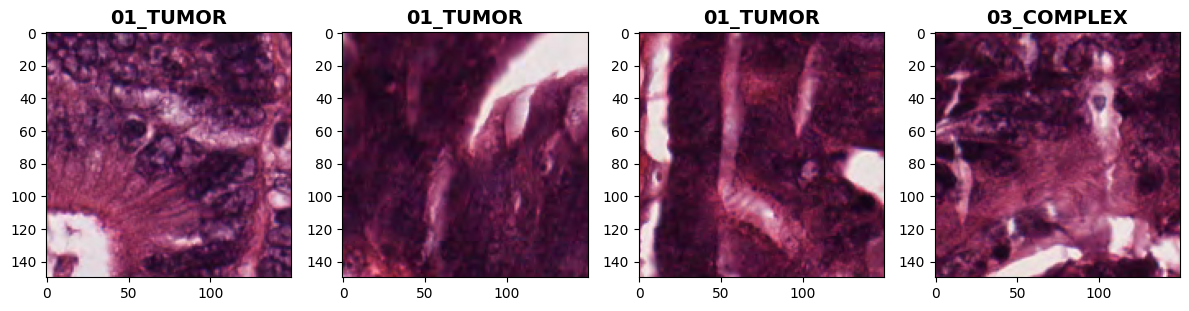

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(12, 6))

indices = [155, 223, 289, 272]

for i, idx in enumerate(indices):
    plt.subplot(1, 4, i+1)
    plt.imshow(data[idx])
    if Y_test[idx] == 0:
        plt.title("01_TUMOR", fontsize=14, fontweight='bold')
    else:
        plt.title("03_COMPLEX", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
name_labels[254]

'01_TUMOR'

In [ ]:
print(classification_report(Y_test, y_pred))

accuracy_all = confusion_matrix.diagonal()/confusion_matrix.sum(axis=1)

for subset in accuracy_all:
    print(subset)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98        88
           1       0.99      0.99      0.99        82
           2       0.95      0.97      0.96        95
           3       0.98      0.99      0.98        94
           4       1.00      0.98      0.99       100
           5       1.00      1.00      1.00        96
           6       0.98      1.00      0.99        97
           7       1.00      0.99      0.99        98

    accuracy                           0.99       750
   macro avg       0.99      0.99      0.99       750
weighted avg       0.99      0.99      0.99       750

0.9659090909090909
0.9878048780487805
0.968421052631579
0.9893617021276596
0.98
1.0
1.0
0.9897959183673469


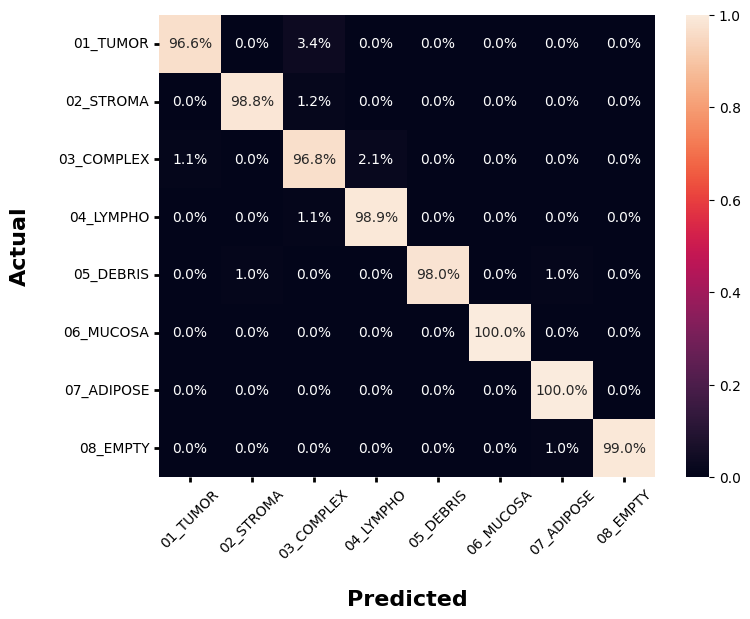

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(Y_test, y_pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(8,6)) # <-- reduce figsize from (10,10) to (8,8)
sns.heatmap(cmn, annot=True, fmt='.1%', xticklabels=img_labels, yticklabels=img_labels, ax=ax)
ax.tick_params(axis='both', which='major', labelsize=10, width=2)
ax.set_ylabel('Actual', fontsize=16, fontweight='bold', labelpad=20)
ax.set_xlabel('Predicted', fontsize=16, fontweight='bold', labelpad=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.show(block=False)


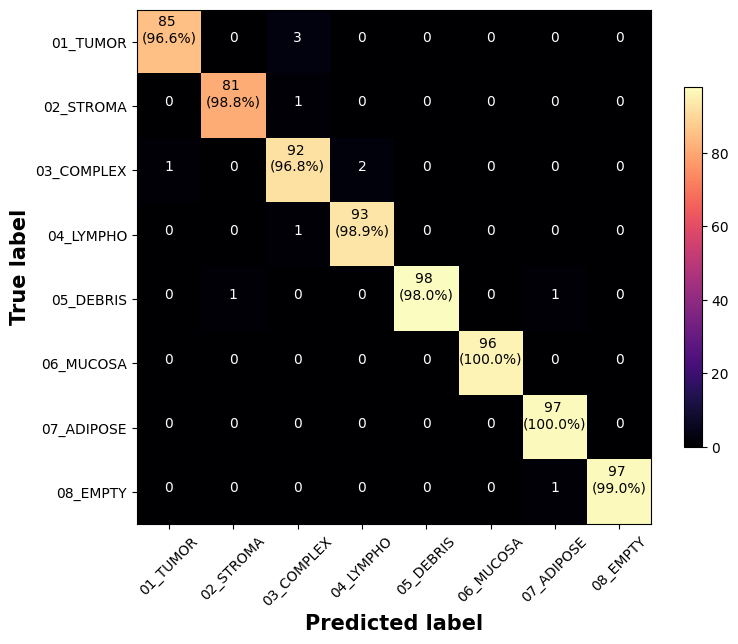

In [ ]:
plot_confusion_matrix(confusion_matrix, classes)

Accuracy score :  0.9968571428571429
Precision score :  0.9968591315876699
Recall score :  0.9968571428571429
F1 score :  0.9968578084421862


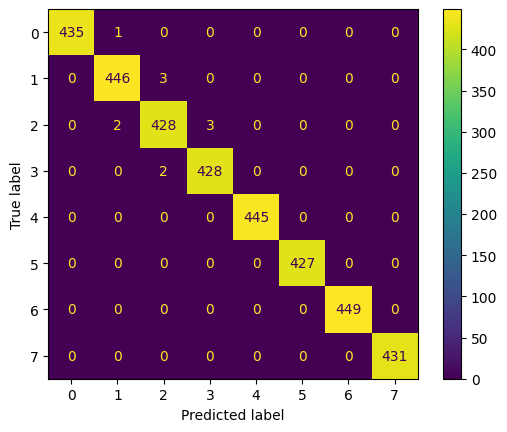

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

y_pred = clf_predict.predict(X_train)

print('Accuracy score : ', accuracy_score(Y_train, y_pred))
print('Precision score : ', precision_score(Y_train, y_pred, average='weighted'))
print('Recall score : ', recall_score(Y_train, y_pred, average='weighted'))
print('F1 score : ', f1_score(Y_train, y_pred, average='weighted'))

confusion_matrix = confusion_matrix(Y_train, y_pred, labels=clf_predict.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix)
disp.plot()
plt.show()